# An Examination of Fitness Data for monitoring Devices

Trivisio aspires to elevate the Colibri Wireless unit to a position of superiority among industry counterparts—Wireless InertiaCube3, MTw Awinda, T40s, and OptoTrak 3020—in the competitive landscape of fitness tracking technology. The foundation of this endeavor is a large dataset derived from 9 subjects who participated in various physical activities while wearing 3 IMUs on 3 different locations and a heart-rate monitor. This dataset, which contains 54 attributes per reading, fuels our search for actionable insights that will not only accurately predict physical activities but also inform strategic decisions.

The Colibri Wireless unit is a versatile tool for activity monitoring due to its integration of sensors measuring acceleration, angular rate, magnetic field, temperature, and orientation.

This report details our analytical journey, from

1. importing libraries
2. data cleaning
3. exploratory data analysis (EDA) and
4. modeling
5. final statement & suggestions for action
6. references

Beyond predictive accuracy, our goal is to derive nuanced insights that can guide potential software enhancements, policy changes, or hardware component modifications. Stay with me on navigating the ever-changing world of fitness tracking, with the goal of positioning Trivisio's Colibri Wireless unit at the forefront of innovation.

In [1]:
#load all the required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pointbiserialr
import matplotlib.ticker as ticker
import statsmodels.api as sm
import glob
import os

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE

# Ignore Caution Signs
import warnings
warnings.filterwarnings('ignore')

The following details are what I learned from the <b>TrivisioColibriwirelessBrochure and Report2_data_info</b> PDF files that were made available to aid in the data formation process.

## Section 1: Data Set Constructions

In [2]:
col_names = ["timestamps", "activityID","heartrate"]

cn_IMUhand = ['wrist_Temperature', 
           'wrist_Acceleration16_x', 'wrist_Acceleration16_y', 'wrist_Acceleration16_z', 
           'wrist_Acceleration6_x', 'wrist_Acceleration6_y', 'wrist_Acceleration6_z', 
           'wrist_Gyroscope_x', 'wrist_Gyroscope_y', 'wrist_Gyroscope_z', 
           'wrist_Magneto_x', 'wrist_Magneto_y', 'wrist_Magneto_z',
           'wrist_Orientation_1', 'wrist_Orientation_2', 'wrist_Orientation_3', 'wrist_Orientation_4']

cn_IMUchest = ['chest_Temperature', 
           'chest_Acceleration16_x', 'chest_Acceleration16_y', 'chest_Acceleration16_z', 
           'chest_Acceleration6_x', 'chest_Acceleration6_y', 'chest_Acceleration6_z', 
           'chest_Gyroscope_x', 'chest_Gyroscope_y', 'chest_Gyroscope_z', 
           'chest_Magneto_x', 'chest_Magneto_y', 'chest_Magneto_z',
           'chest_Orientation_1', 'chest_Orientation_2', 'chest_Orientation_3', 'chest_Orientation_4']

cn_IMUankle = ['ankle_Temperature', 
           'ankle_Acceleration16_x', 'ankle_Acceleration16_y', 'ankle_Acceleration16_z', 
           'ankle_Acceleration6_x', 'ankle_Acceleration6_y', 'ankle_Acceleration6_z', 
           'ankle_Gyroscope_x', 'ankle_Gyroscope_y', 'ankle_Gyroscope_z', 
           'ankle_Magneto_x', 'ankle_Magneto_y', 'ankle_Magneto_z',
           'ankle_Orientation_1', 'ankle_Orientation_2', 'ankle_Orientation_3', 'ankle_Orientation_4']

col_id = ['Subject_ID']

main_col = col_names+cn_IMUhand+cn_IMUchest+cn_IMUankle+col_id

In [3]:
#length of the columns
len(main_col)

55

The subjectInformation file, DataCollectionProtocol, DescriptionOfActivities and PerformedActivitiesSummary was used to create the table subj_info and activity_info below.

In [4]:
subj_info = {
    "Subject_ID": [101,102,103,104,105,106,107,108,109],
    "Sex":["Male","Female","Male","Male","Male","Male","Male","Male","Male"],
    "Age (years)":[27,25,31,24,26,26,23,32,31],
    "Height (cm)":[182,169,187,194,180,183,173,179,168],
    "Weight (kg)":[83,78,92,95,73,69,86,87,65],
    "Resting HR (bpm)":[75,74,68,58,70,60,60,66,54],
    "Max HR (bpm)":[193,195,189,196,194,194,197,188,189],
    "Dominant hand":["right","right","right","right","right","right","right","bleft","right"]
}

subject_df = pd.DataFrame(subj_info)
display(subject_df)

Subject_ID     Sex  Age (years)  Height (cm)  Weight (kg)  \
0         101    Male           27          182           83   
1         102  Female           25          169           78   
2         103    Male           31          187           92   
3         104    Male           24          194           95   
4         105    Male           26          180           73   
5         106    Male           26          183           69   
6         107    Male           23          173           86   
7         108    Male           32          179           87   
8         109    Male           31          168           65   

   Resting HR (bpm)  Max HR (bpm) Dominant hand  
0                75           193         right  
1                74           195         right  
2                68           189         right  
3                58           196         right  
4                70           194         right  
5                60           194         right  
6                60           197         right  
7                66           188         bleft  
8                54           189         right

In [5]:
activity_info = {
    "activityID": [1,2,3,4,5,6,7,9,10,11,12,13,16,17,18,19,20,24,0],
    "activity":["lying","sitting","standing","walking","running","cycling","Nordic walking","watching TV","computer work","car driving","ascending stairs","descending stairs","vacuum cleaning","ironing","folding laundry","house cleaning","playing soccer","rope jumping","other (transient activities)"],
    "pace":["light","light","light","moderate","vigorous","moderate","moderate","-","-","-","moderate","moderate","light","light","-","-","vigorous","vigorous","-"],
    "MET":["1.0","1.8","1.8","3.5","7.5","4.0","5.5","1.0","1.8","1.8","8.0","3.0","3.5","2.3","2.3","3.5","7.5","9.0","-"]
}

activity_df = pd.DataFrame(activity_info)
display(activity_df)

activityID                      activity      pace  MET
0            1                         lying     light  1.0
1            2                       sitting     light  1.8
2            3                      standing     light  1.8
3            4                       walking  moderate  3.5
4            5                       running  vigorous  7.5
5            6                       cycling  moderate  4.0
6            7                Nordic walking  moderate  5.5
7            9                   watching TV         -  1.0
8           10                 computer work         -  1.8
9           11                   car driving         -  1.8
10          12              ascending stairs  moderate  8.0
11          13             descending stairs  moderate  3.0
12          16               vacuum cleaning     light  3.5
13          17                       ironing     light  2.3
14          18               folding laundry         -  2.3
15          19                house cleaning         -  3.5
16          20                playing soccer  vigorous  7.5
17          24                  rope jumping  vigorous  9.0
18           0  other (transient activities)         -    -

We must read the dat files, whichs contain all the information, in order to form the data.

In [6]:
# read_csv used to read .dat file with the use delimiter
df_set1 = pd.read_csv("Dataset/protocol/subject101.dat", delimiter='\t')
display(df_set1)

8.38 0 104 30 2.37223 8.60074 3.51048 2.43954 8.76165 3.35465 -0.0922174 0.0568115 -0.0158445 14.6806 -69.2128 -5.58905 1 0 0 0 31.8125 0.23808 9.80003 -1.68896 0.265304 9.81549 -1.41344 -0.00506495 -0.00678097 -0.00566295 0.47196 -51.0499 43.2903 1 0 0 0 30.3125 9.65918 -1.65569 -0.0997967 9.64689 -1.55576 0.310404 0.00830026 0.00925038 -0.0175803 -61.1888 -38.9599 -58.1438 1 0 0 0
0       8.39 0 NaN 30 2.18837 8.5656 3.66179 2.39494 8...                                                                                                                                                                                                                                                                                                                                               
1       8.4 0 NaN 30 2.37357 8.60107 3.54898 2.30514 8...                                                                                                                                                                                                                                                                                                                                               
2       8.41 0 NaN 30 2.07473 8.52853 3.66021 2.33528 ...                                                                                                                                                                                                                                                                                                                                               
3       8.42 0 NaN 30 2.22936 8.83122 3.7 2.23055 8.59...                                                                                                                                                                                                                                                                                                                                               
4       8.43 0 NaN 30 2.29959 8.82929 3.5471 2.26132 8...                                                                                                                                                                                                                                                                                                                                               
...                                                   ...                                                                                                                                                                                                                                                                                                                                               
376411  3772.5 0 NaN 30.5 2.02477 7.29553 5.74194 2.06...                                                                                                                                                                                                                                                                                                                                               
376412  3772.51 0 NaN 30.5 2.10836 7.86504 5.85674 2.0...                                                                                                                                                                                                                                                                                                                                               
376413  3772.52 0 NaN 30.5 2.07163 8.39581 5.77742 2.1...                                                                                                                                                                                                                                                                                                                                               
376414  3772.53 0 NaN 30.5 2.19569 8.77634 6.00892 2.1...                    

In [7]:
# forming a list of dat file names using os.path
file_pattern = 'Dataset/protocol/*.dat'
file_box = glob.glob(file_pattern)
file_box = [os.path.basename(file) for file in file_box]
file_box

['subject101.dat',
 'subject102.dat',
 'subject103.dat',
 'subject104.dat',
 'subject105.dat',
 'subject106.dat',
 'subject107.dat',
 'subject108.dat',
 'subject109.dat']

The following for loop eliminates the hassle of merging one file at a time by reading nine dat files simultaneously.

In [8]:
main_df = pd.DataFrame() 
for i in range(0,len(file_box)): 
    file_url = "Dataset/protocol/"+file_box[i]
    print(file_url)
    data = pd.read_csv(file_url, header=None, delimiter='\s+')
    data['subject_ID'] = int(file_url[-5])
    print(data)
    main_df = main_df.append([data],ignore_index=True)
print(main_df)

Dataset/protocol/subject101.dat
              0  1      2     3        4        5        6        7        8  \
0          8.38  0  104.0  30.0  2.37223  8.60074  3.51048  2.43954  8.76165   
1          8.39  0    NaN  30.0  2.18837  8.56560  3.66179  2.39494  8.55081   
2          8.40  0    NaN  30.0  2.37357  8.60107  3.54898  2.30514  8.53644   
3          8.41  0    NaN  30.0  2.07473  8.52853  3.66021  2.33528  8.53622   
4          8.42  0    NaN  30.0  2.22936  8.83122  3.70000  2.23055  8.59741   
...         ... ..    ...   ...      ...      ...      ...      ...      ...   
376412  3772.50  0    NaN  30.5  2.02477  7.29553  5.74194  2.06573  6.57692   
376413  3772.51  0    NaN  30.5  2.10836  7.86504  5.85674  2.08754  7.42244   
376414  3772.52  0    NaN  30.5  2.07163  8.39581  5.77742  2.13833  8.05640   
376415  3772.53  0    NaN  30.5  2.19569  8.77634  6.00892  2.11251  8.53989   
376416  3772.54  0    NaN  30.5  2.14774  8.66047  5.73918  2.15810  8.59995   

       

In [9]:
# here I am assigning the columns to the dataframe
main_df.reset_index(drop=True,inplace=True)
main_df.columns=main_col

The activity table and main_df, which contains data from the dat files according to the activityID, are being combined below. I'm not using the subj_info table because it only has one female and eight males in terms of gender data, which suggests that there may have been a compromise somewhere.

In [10]:
main_df=pd.merge(main_df,activity_df, on='activityID', how='inner')
display(main_df)

timestamps  activityID  heartrate  wrist_Temperature  \
0              8.38           0      104.0             30.000   
1              8.39           0        NaN             30.000   
2              8.40           0        NaN             30.000   
3              8.41           0        NaN             30.000   
4              8.42           0        NaN             30.000   
...             ...         ...        ...                ...   
2872528       95.06          24        NaN             25.125   
2872529       95.07          24        NaN             25.125   
2872530       95.08          24        NaN             25.125   
2872531       95.09          24      162.0             25.125   
2872532       95.10          24        NaN             25.125   

         wrist_Acceleration16_x  wrist_Acceleration16_y  \
0                       2.37223                 8.60074   
1                       2.18837                 8.56560   
2                       2.37357                 8.60107   
3                       2.07473                 8.52853   
4                       2.22936                 8.83122   
...                         ...                     ...   
2872528                 4.99466                 6.01881   
2872529                 5.02764                 5.90369   
2872530                 5.06409                 5.71370   
2872531                 5.13914                 5.63724   
2872532                 5.00812                 5.40645   

         wrist_Acceleration16_z  wrist_Acceleration6_x  wrist_Acceleration6_y  \
0                       3.51048                2.43954                8.76165   
1                       3.66179                2.39494                8.55081   
2                       3.54898                2.30514                8.53644   
3                       3.66021                2.33528                8.53622   
4                       3.70000                2.23055                8.59741   
...                         ...                    ...                    ...   
2872528                 5.59830                4.90787                6.05780   
2872529                 5.48372                4.89090                5.95209   
2872530                 5.48491                4.97981                5.87584   
2872531                 5.48629                4.97690                5.69448   
2872532                 5.02326                4.97362                5.45272   

         wrist_Acceleration6_z  ...  ankle_Magneto_y  ankle_Magneto_z  \
0                      3.35465  ...       -38.959900       -58.143800   
1                      3.64207  ...       -38.891900       -58.525300   
2                      3.73280  ...       -39.413800       -58.399900   
3                      3.73277  ...       -38.763500       -58.395600   
4                      3.76295  ...       -39.387900       -58.269400   
...                        ...  ...              ...              ...   
2872528                5.68357  ...        -0.831734        -0.170139   
2872529                5.56301  ...        -0.817288         0.538134   
2872530                5.45738  ...        -1.229410         0.540438   
2872531                5.29167  ...        -0.565555         0.680109   
2872532                5.14120  ...        -0.812965        -0.313346   

         ankle_Orientation_1  ankle_Orientation_2  ankle_Orientation_3  \
0                   1.000000             0.000000             0.000000   
1                   1.000000             0.000000             0.000000   
2                   1.000000             0.000000             0.000000   
3                   1.000000             0.000000             0.000000   
4                   1.000000             0.000000             0.000000   
...                      ...                  ...                  ...   
2872528             0.522929            -0.291612             0.705786   
2872529             0.522880            -0.291694             0.705895   
287

### Step 2: Gaining an overview of the entire data set in order to begin wrangling and cleaning.

In [11]:
#display dataframe
m_df = main_df.copy(deep=True)
m_df

timestamps  activityID  heartrate  wrist_Temperature  \
0              8.38           0      104.0             30.000   
1              8.39           0        NaN             30.000   
2              8.40           0        NaN             30.000   
3              8.41           0        NaN             30.000   
4              8.42           0        NaN             30.000   
...             ...         ...        ...                ...   
2872528       95.06          24        NaN             25.125   
2872529       95.07          24        NaN             25.125   
2872530       95.08          24        NaN             25.125   
2872531       95.09          24      162.0             25.125   
2872532       95.10          24        NaN             25.125   

         wrist_Acceleration16_x  wrist_Acceleration16_y  \
0                       2.37223                 8.60074   
1                       2.18837                 8.56560   
2                       2.37357                 8.60107   
3                       2.07473                 8.52853   
4                       2.22936                 8.83122   
...                         ...                     ...   
2872528                 4.99466                 6.01881   
2872529                 5.02764                 5.90369   
2872530                 5.06409                 5.71370   
2872531                 5.13914                 5.63724   
2872532                 5.00812                 5.40645   

         wrist_Acceleration16_z  wrist_Acceleration6_x  wrist_Acceleration6_y  \
0                       3.51048                2.43954                8.76165   
1                       3.66179                2.39494                8.55081   
2                       3.54898                2.30514                8.53644   
3                       3.66021                2.33528                8.53622   
4                       3.70000                2.23055                8.59741   
...                         ...                    ...                    ...   
2872528                 5.59830                4.90787                6.05780   
2872529                 5.48372                4.89090                5.95209   
2872530                 5.48491                4.97981                5.87584   
2872531                 5.48629                4.97690                5.69448   
2872532                 5.02326                4.97362                5.45272   

         wrist_Acceleration6_z  ...  ankle_Magneto_y  ankle_Magneto_z  \
0                      3.35465  ...       -38.959900       -58.143800   
1                      3.64207  ...       -38.891900       -58.525300   
2                      3.73280  ...       -39.413800       -58.399900   
3                      3.73277  ...       -38.763500       -58.395600   
4                      3.76295  ...       -39.387900       -58.269400   
...                        ...  ...              ...              ...   
2872528                5.68357  ...        -0.831734        -0.170139   
2872529                5.56301  ...        -0.817288         0.538134   
2872530                5.45738  ...        -1.229410         0.540438   
2872531                5.29167  ...        -0.565555         0.680109   
2872532                5.14120  ...        -0.812965        -0.313346   

         ankle_Orientation_1  ankle_Orientation_2  ankle_Orientation_3  \
0                   1.000000             0.000000             0.000000   
1                   1.000000             0.000000             0.000000   
2                   1.000000             0.000000             0.000000   
3                   1.000000             0.000000             0.000000   
4                   1.000000             0.000000             0.000000   
...                      ...                  ...                  ...   
2872528             0.522929            -0.291612             0.705786   
2872529             0.522880            -0.291694             0.705895   
287

In [12]:
#displays 1st 5 rows
m_df.head()

timestamps  activityID  heartrate  wrist_Temperature  \
0        8.38           0      104.0               30.0   
1        8.39           0        NaN               30.0   
2        8.40           0        NaN               30.0   
3        8.41           0        NaN               30.0   
4        8.42           0        NaN               30.0   

   wrist_Acceleration16_x  wrist_Acceleration16_y  wrist_Acceleration16_z  \
0                 2.37223                 8.60074                 3.51048   
1                 2.18837                 8.56560                 3.66179   
2                 2.37357                 8.60107                 3.54898   
3                 2.07473                 8.52853                 3.66021   
4                 2.22936                 8.83122                 3.70000   

   wrist_Acceleration6_x  wrist_Acceleration6_y  wrist_Acceleration6_z  ...  \
0                2.43954                8.76165                3.35465  ...   
1                2.39494                8.55081                3.64207  ...   
2                2.30514                8.53644                3.73280  ...   
3                2.33528                8.53622                3.73277  ...   
4                2.23055                8.59741                3.76295  ...   

   ankle_Magneto_y  ankle_Magneto_z  ankle_Orientation_1  ankle_Orientation_2  \
0         -38.9599         -58.1438                  1.0                  0.0   
1         -38.8919         -58.5253                  1.0                  0.0   
2         -39.4138         -58.3999                  1.0                  0.0   
3         -38.7635         -58.3956                  1.0                  0.0   
4         -39.3879         -58.2694                  1.0                  0.0   

   ankle_Orientation_3  ankle_Orientation_4  Subject_ID  \
0                  0.0                  0.0           1   
1                  0.0                  0.0           1   
2                  0.0                  0.0           1   
3                  0.0                  0.0           1   
4                  0.0                  0.0           1   

                       activity  pace  MET  
0  other (transient activities)     -    -  
1  other (transient activities)     -    -  
2  other (transient activities)     -    -  
3  other (transient activities)     -    -  
4  other (transient activities)     -    -  

[5 rows x 58 columns]

In [13]:
#displays last 5 rows 
m_df.tail()

timestamps  activityID  heartrate  wrist_Temperature  \
2872528       95.06          24        NaN             25.125   
2872529       95.07          24        NaN             25.125   
2872530       95.08          24        NaN             25.125   
2872531       95.09          24      162.0             25.125   
2872532       95.10          24        NaN             25.125   

         wrist_Acceleration16_x  wrist_Acceleration16_y  \
2872528                 4.99466                 6.01881   
2872529                 5.02764                 5.90369   
2872530                 5.06409                 5.71370   
2872531                 5.13914                 5.63724   
2872532                 5.00812                 5.40645   

         wrist_Acceleration16_z  wrist_Acceleration6_x  wrist_Acceleration6_y  \
2872528                 5.59830                4.90787                6.05780   
2872529                 5.48372                4.89090                5.95209   
2872530                 5.48491                4.97981                5.87584   
2872531                 5.48629                4.97690                5.69448   
2872532                 5.02326                4.97362                5.45272   

         wrist_Acceleration6_z  ...  ankle_Magneto_y  ankle_Magneto_z  \
2872528                5.68357  ...        -0.831734        -0.170139   
2872529                5.56301  ...        -0.817288         0.538134   
2872530                5.45738  ...        -1.229410         0.540438   
2872531                5.29167  ...        -0.565555         0.680109   
2872532                5.14120  ...        -0.812965        -0.313346   

         ankle_Orientation_1  ankle_Orientation_2  ankle_Orientation_3  \
2872528             0.522929            -0.291612             0.705786   
2872529             0.522880            -0.291694             0.705895   
2872530             0.522625            -0.291978             0.706161   
2872531             0.522536            -0.291955             0.706426   
2872532             0.522730            -0.291275             0.706526   

         ankle_Orientation_4  Subject_ID      activity      pace  MET  
2872528            -0.378648           9  rope jumping  vigorous  9.0  
2872529            -0.378450           9  rope jumping  vigorous  9.0  
2872530            -0.378084           9  rope jumping  vigorous  9.0  
2872531            -0.377733           9  rope jumping  vigorous  9.0  
2872532            -0.377800           9  rope jumping  vigorous  9.0  

[5 rows x 58 columns]

Because the orientation data is marked as "invalid in this data collection" (mentioned in Report2_data_info), I removed it as part of the data cleaning process. I also removed a few other aspects as suggested by the data suppliers as below:

In [14]:
m_df.drop(['wrist_Orientation_1',
         'wrist_Orientation_2',
         'wrist_Orientation_3',
         'wrist_Orientation_4',
         'chest_Orientation_1',
         'chest_Orientation_2',
         'chest_Orientation_3',
         'chest_Orientation_4',
         'ankle_Orientation_1',
         'ankle_Orientation_2',
         'ankle_Orientation_3',
         'ankle_Orientation_4'], axis = 1, inplace=True)

<b>The accelerometer ±6g  was not calibrated precisely with this one. Furthermore, it occasionally becomes saturated because of the high impacts brought on by specific movements (like running) with accelerations greater than 6g. Consequently, it is advised to use the first accelerometer's data, which has a scale of ±16g. Hence, I am removing the accelerometer ±6g column.</b>

In [15]:
m_df.drop(['wrist_Acceleration6_x',
         'wrist_Acceleration6_y',
         'wrist_Acceleration6_z',
         'chest_Acceleration6_x',
         'chest_Acceleration6_y',
         'chest_Acceleration6_z',
         'ankle_Acceleration6_x',
         'ankle_Acceleration6_y',
         'ankle_Acceleration6_z'], axis = 1, inplace=True)

<b>Next, I dropped any rows with activityid=0 which comes to around 929661 rows, as its mentioned to be disregarded in Report2_data_info by the data collector.</b>

In [16]:
m_df = m_df.drop(m_df[m_df.activityID == 0].index)
m_df.reset_index(drop=True,inplace=True)
display(m_df)

timestamps  activityID  heartrate  wrist_Temperature  \
0             37.66           1        NaN             30.375   
1             37.67           1        NaN             30.375   
2             37.68           1        NaN             30.375   
3             37.69           1        NaN             30.375   
4             37.70           1      100.0             30.375   
...             ...         ...        ...                ...   
1942867       95.06          24        NaN             25.125   
1942868       95.07          24        NaN             25.125   
1942869       95.08          24        NaN             25.125   
1942870       95.09          24      162.0             25.125   
1942871       95.10          24        NaN             25.125   

         wrist_Acceleration16_x  wrist_Acceleration16_y  \
0                       2.21530                 8.27915   
1                       2.29196                 7.67288   
2                       2.29090                 7.14240   
3                       2.21800                 7.14365   
4                       2.30106                 7.25857   
...                         ...                     ...   
1942867                 4.99466                 6.01881   
1942868                 5.02764                 5.90369   
1942869                 5.06409                 5.71370   
1942870                 5.13914                 5.63724   
1942871                 5.00812                 5.40645   

         wrist_Acceleration16_z  wrist_Gyroscope_x  wrist_Gyroscope_y  \
0                       5.58753          -0.004750           0.037579   
1                       5.74467          -0.171710           0.025479   
2                       5.82342          -0.238241           0.011214   
3                       5.89930          -0.192912           0.019053   
4                       6.09259          -0.069961          -0.018328   
...                         ...                ...                ...   
1942867                 5.59830          -0.289166          -0.110170   
1942868                 5.48372          -0.275411          -0.128358   
1942869                 5.48491          -0.289885          -0.126548   
1942870                 5.48629          -0.234417          -0.101485   
1942871                 5.02326          -0.260924          -0.093849   

         wrist_Gyroscope_z  ...  ankle_Gyroscope_x  ankle_Gyroscope_y  \
0                -0.011145  ...           0.002908          -0.027714   
1                -0.009538  ...           0.020882           0.000945   
2                 0.000831  ...          -0.035392          -0.052422   
3                 0.013374  ...          -0.032514          -0.018844   
4                 0.004582  ...           0.001351          -0.048878   
...                    ...  ...                ...                ...   
1942867           0.238570  ...           0.021288          -0.012885   
1942868           0.267409  ...           0.010715           0.003629   
1942869           0.281483  ...          -0.016939          -0.035176   
1942870           0.275497  ...          -0.028069          -0.036457   
1942871           0.266205  ...          -0.013310          -0.030195   

         ankle_Gyroscope_z  ankle_Magneto_x  ankle_Magneto_y  ankle_Magneto_z  \
0                 0.001752         -61.1081       -36.863600       -58.369600   
1                 0.006007         -60.8916       -36.319700       -58.365600   
2                -0.004882         -60.3407       -35.784200       -58.611900   
3                 0.026950         -60.7646       -37.102800       -57.879900   
4                -0.006328         -60.2040       -37.122500       -57.884700   
...                    ...              ...              ...              ...   
1942867           0.005878         -45.7855        -0.831734        -0.170139   
1942868          -0.004235         -46.0331        -0.817288         0.538134   
1942869          -0.002309         -

In [17]:
m_df['heartrate'].value_counts()

124.0    3462
79.0     3368
90.0     3347
122.0    3187
120.0    3185
         ... 
197.0      24
186.0      24
185.0      24
184.0      16
202.0       8
Name: heartrate, Length: 146, dtype: int64

### Data Cleaning
Deleting null values

In [18]:
# below I am counting the values present in each column in an ascending order
m_df.count().sort_values(ascending=False)

timestamps                1942872
activityID                1942872
pace                      1942872
activity                  1942872
Subject_ID                1942872
MET                       1942872
chest_Magneto_y           1940452
chest_Acceleration16_x    1940452
chest_Magneto_z           1940452
chest_Magneto_x           1940452
chest_Gyroscope_z         1940452
chest_Gyroscope_x         1940452
chest_Acceleration16_z    1940452
chest_Acceleration16_y    1940452
chest_Gyroscope_y         1940452
chest_Temperature         1940452
ankle_Acceleration16_x    1934365
ankle_Magneto_z           1934365
ankle_Magneto_y           1934365
ankle_Magneto_x           1934365
ankle_Gyroscope_z         1934365
ankle_Gyroscope_y         1934365
ankle_Gyroscope_x         1934365
ankle_Acceleration16_y    1934365
ankle_Acceleration16_z    1934365
ankle_Temperature         1934365
wrist_Magneto_z           1931748
wrist_Gyroscope_y         1931748
wrist_Gyroscope_x         1931748
wrist_Gyroscop

In [19]:
# below I'm printing the nullvalues in form of percentage in a descending order
round(100*(m_df.isnull().sum().sort_values(ascending=False)/len(m_df.index)), 2)

heartrate                 90.87
wrist_Magneto_y            0.57
wrist_Temperature          0.57
wrist_Acceleration16_x     0.57
wrist_Acceleration16_y     0.57
wrist_Acceleration16_z     0.57
wrist_Gyroscope_x          0.57
wrist_Gyroscope_y          0.57
wrist_Gyroscope_z          0.57
wrist_Magneto_x            0.57
wrist_Magneto_z            0.57
ankle_Gyroscope_y          0.44
ankle_Acceleration16_x     0.44
ankle_Acceleration16_y     0.44
ankle_Acceleration16_z     0.44
ankle_Gyroscope_x          0.44
ankle_Magneto_z            0.44
ankle_Gyroscope_z          0.44
ankle_Magneto_x            0.44
ankle_Magneto_y            0.44
ankle_Temperature          0.44
chest_Magneto_z            0.12
chest_Gyroscope_y          0.12
chest_Magneto_y            0.12
chest_Magneto_x            0.12
chest_Gyroscope_z          0.12
chest_Gyroscope_x          0.12
chest_Acceleration16_y     0.12
chest_Acceleration16_x     0.12
chest_Temperature          0.12
chest_Acceleration16_z     0.12
pace    

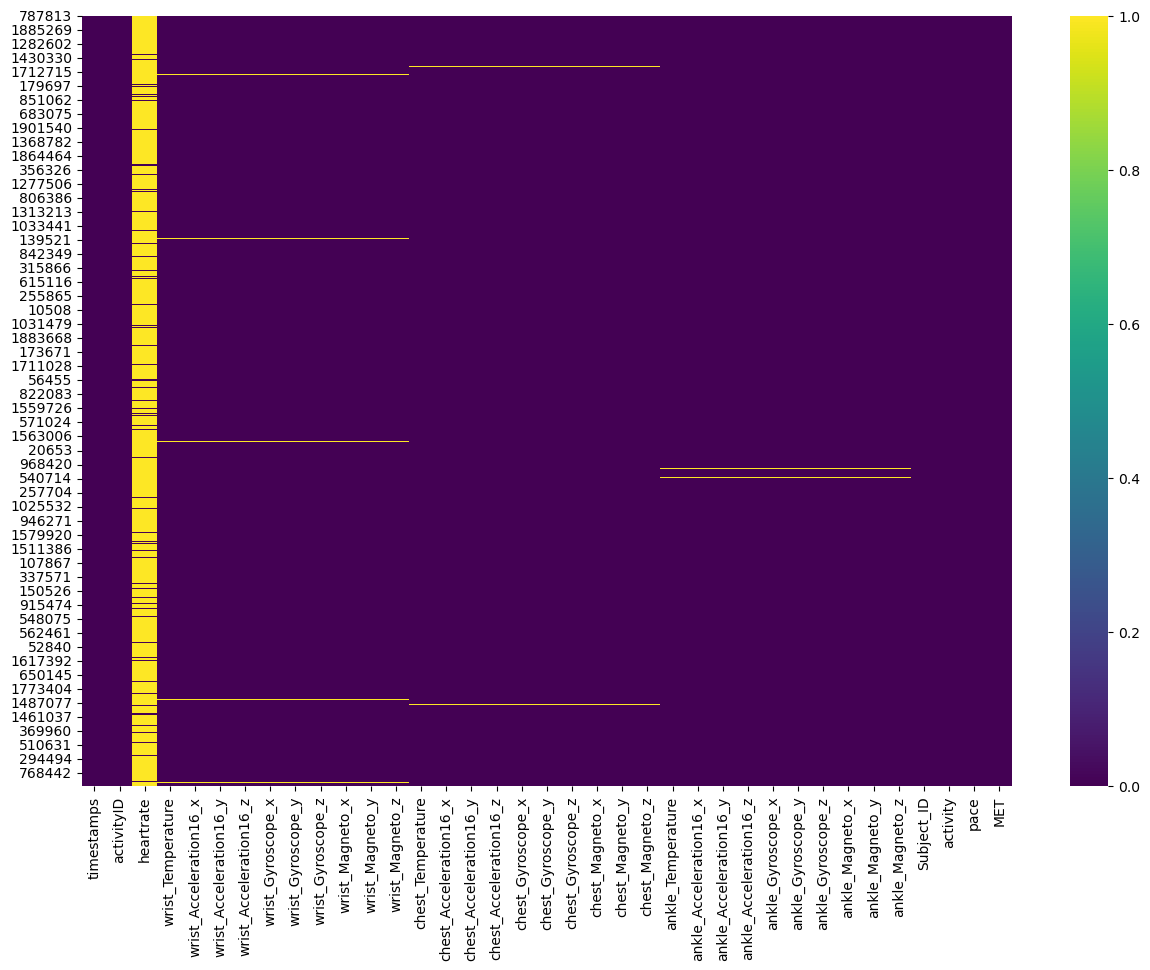

In [20]:
df_subset = m_df.sample(n=10000, random_state=42)

# Create a heatmap for missing values
plt.figure(figsize=(15, 10))
sns.heatmap(df_subset.isnull(), cbar=True, cmap='viridis')
plt.show()

In [21]:
m_df = m_df.interpolate()

In [22]:
m_df.reset_index(drop=True,inplace=True)
round(100*(m_df.isnull().sum().sort_values(ascending=False)/len(m_df.index)), 2)

heartrate                 0.0
timestamps                0.0
ankle_Gyroscope_y         0.0
chest_Magneto_y           0.0
chest_Magneto_z           0.0
ankle_Temperature         0.0
ankle_Acceleration16_x    0.0
ankle_Acceleration16_y    0.0
ankle_Acceleration16_z    0.0
ankle_Gyroscope_x         0.0
ankle_Gyroscope_z         0.0
chest_Gyroscope_z         0.0
ankle_Magneto_x           0.0
ankle_Magneto_y           0.0
ankle_Magneto_z           0.0
Subject_ID                0.0
activity                  0.0
pace                      0.0
chest_Magneto_x           0.0
chest_Gyroscope_y         0.0
activityID                0.0
wrist_Gyroscope_z         0.0
wrist_Temperature         0.0
wrist_Acceleration16_x    0.0
wrist_Acceleration16_y    0.0
wrist_Acceleration16_z    0.0
wrist_Gyroscope_x         0.0
wrist_Gyroscope_y         0.0
wrist_Magneto_x           0.0
chest_Gyroscope_x         0.0
wrist_Magneto_y           0.0
wrist_Magneto_z           0.0
chest_Temperature         0.0
chest_Acce

The first entry in column "heartrate" remains NaN since there isn't a prior record there that may be utilised for interpolation, which is why it is showing 4. In order to fill that space with a value, I'm using iloc to fill that space with the first instant value and the index numbers.

In [23]:
m_df.isna().sum().sort_values(ascending=False)

heartrate                 4
timestamps                0
ankle_Gyroscope_y         0
chest_Magneto_y           0
chest_Magneto_z           0
ankle_Temperature         0
ankle_Acceleration16_x    0
ankle_Acceleration16_y    0
ankle_Acceleration16_z    0
ankle_Gyroscope_x         0
ankle_Gyroscope_z         0
chest_Gyroscope_z         0
ankle_Magneto_x           0
ankle_Magneto_y           0
ankle_Magneto_z           0
Subject_ID                0
activity                  0
pace                      0
chest_Magneto_x           0
chest_Gyroscope_y         0
activityID                0
wrist_Gyroscope_z         0
wrist_Temperature         0
wrist_Acceleration16_x    0
wrist_Acceleration16_y    0
wrist_Acceleration16_z    0
wrist_Gyroscope_x         0
wrist_Gyroscope_y         0
wrist_Magneto_x           0
chest_Gyroscope_x         0
wrist_Magneto_y           0
wrist_Magneto_z           0
chest_Temperature         0
chest_Acceleration16_x    0
chest_Acceleration16_y    0
chest_Acceleration16

In [24]:
for i in range(0,4):
    m_df["heartrate"].iloc[i]=100

In [25]:
m_df.isna().sum()

timestamps                0
activityID                0
heartrate                 0
wrist_Temperature         0
wrist_Acceleration16_x    0
wrist_Acceleration16_y    0
wrist_Acceleration16_z    0
wrist_Gyroscope_x         0
wrist_Gyroscope_y         0
wrist_Gyroscope_z         0
wrist_Magneto_x           0
wrist_Magneto_y           0
wrist_Magneto_z           0
chest_Temperature         0
chest_Acceleration16_x    0
chest_Acceleration16_y    0
chest_Acceleration16_z    0
chest_Gyroscope_x         0
chest_Gyroscope_y         0
chest_Gyroscope_z         0
chest_Magneto_x           0
chest_Magneto_y           0
chest_Magneto_z           0
ankle_Temperature         0
ankle_Acceleration16_x    0
ankle_Acceleration16_y    0
ankle_Acceleration16_z    0
ankle_Gyroscope_x         0
ankle_Gyroscope_y         0
ankle_Gyroscope_z         0
ankle_Magneto_x           0
ankle_Magneto_y           0
ankle_Magneto_z           0
Subject_ID                0
activity                  0
pace                

In [26]:
# checking duplicates here
print(f"Any duplicate values?: {m_df.duplicated().any()}")
sum(m_df.duplicated())

Any duplicate values?: False


0

In [27]:
# checking if there is heartrate equal to 300
m_df['heartrate'].isin([300]).any()

False

In [28]:
main_ds=m_df.copy(deep=True)

In [29]:
#displays the shape of data
main_ds.shape

(1942872, 37)

### Data Wrangling

To improve data quality, a process known as "data wrangling" involves converting and organizing data from one raw form into a desired format.

In [30]:
# displays the list of column names
main_ds.columns

Index(['timestamps', 'activityID', 'heartrate', 'wrist_Temperature',
       'wrist_Acceleration16_x', 'wrist_Acceleration16_y',
       'wrist_Acceleration16_z', 'wrist_Gyroscope_x', 'wrist_Gyroscope_y',
       'wrist_Gyroscope_z', 'wrist_Magneto_x', 'wrist_Magneto_y',
       'wrist_Magneto_z', 'chest_Temperature', 'chest_Acceleration16_x',
       'chest_Acceleration16_y', 'chest_Acceleration16_z', 'chest_Gyroscope_x',
       'chest_Gyroscope_y', 'chest_Gyroscope_z', 'chest_Magneto_x',
       'chest_Magneto_y', 'chest_Magneto_z', 'ankle_Temperature',
       'ankle_Acceleration16_x', 'ankle_Acceleration16_y',
       'ankle_Acceleration16_z', 'ankle_Gyroscope_x', 'ankle_Gyroscope_y',
       'ankle_Gyroscope_z', 'ankle_Magneto_x', 'ankle_Magneto_y',
       'ankle_Magneto_z', 'Subject_ID', 'activity', 'pace', 'MET'],
      dtype='object')

In [31]:
# as the column names where big and in camel case, I renamed them using rename for keeping it standard  
columns ={"activityID":"activityid",
          "wrist_Temperature":"wrist_temperature",
          "wrist_Acceleration16_x":"wrist_accelerat16_x",
          "wrist_Acceleration16_y":"wrist_accelerat16_y",
          "wrist_Acceleration16_z":"wrist_accelerat16_z",
          "wrist_Gyroscope_x":"wrist_gyroscope_x",
          "wrist_Gyroscope_y":"wrist_gyroscope_y",
          "wrist_Gyroscope_z":"wrist_gyroscope_z",
          "wrist_Magneto_x":"wrist_magneto_x",
          "wrist_Magneto_y":"wrist_magneto_y",
          "wrist_Magneto_z":"wrist_magneto_z",
          "chest_Temperature":"chest_temperature",
          "chest_Acceleration16_x":"chest_accelerat16_x",
          "chest_Acceleration16_y":"chest_accelerat16_y",
          "chest_Acceleration16_z":"chest_accelerat16_z",
          "chest_Gyroscope_x":"chest_gyroscope_x",
          "chest_Gyroscope_y":"chest_gyroscope_y",
          "chest_Gyroscope_z":"chest_gyroscope_z",
          "chest_Magneto_x":"chest_magneto_x",
          "chest_Magneto_y":"chest_magneto_y",
          "chest_Magneto_z":"chest_magneto_z",
          "ankle_Temperature":"ankle_temperature",
          "ankle_Acceleration16_x":"ankle_accelerat16_x",
          "ankle_Acceleration16_y":"ankle_accelerat16_y",
          "ankle_Acceleration16_z":"ankle_accelerat16_z",
          "ankle_Gyroscope_x":"ankle_gyroscope_x",
          "ankle_Gyroscope_y":"ankle_gyroscope_y",
          "ankle_Gyroscope_z":"ankle_gyroscope_z",
          "ankle_Magneto_x":"ankle_magneto_x",
          "ankle_Magneto_y":"ankle_magneto_y",
          "ankle_Magneto_z":"ankle_magneto_z",
          "Subject_ID":"subject_id",
          "MET":"met"
         }

In [32]:
# renaming column names using rename
main_ds.rename(columns=columns,inplace=True)
display(main_ds)

timestamps  activityid  heartrate  wrist_temperature  \
0             37.66           1      100.0             30.375   
1             37.67           1      100.0             30.375   
2             37.68           1      100.0             30.375   
3             37.69           1      100.0             30.375   
4             37.70           1      100.0             30.375   
...             ...         ...        ...                ...   
1942867       95.06          24      162.0             25.125   
1942868       95.07          24      162.0             25.125   
1942869       95.08          24      162.0             25.125   
1942870       95.09          24      162.0             25.125   
1942871       95.10          24      162.0             25.125   

         wrist_accelerat16_x  wrist_accelerat16_y  wrist_accelerat16_z  \
0                    2.21530              8.27915              5.58753   
1                    2.29196              7.67288              5.74467   
2                    2.29090              7.14240              5.82342   
3                    2.21800              7.14365              5.89930   
4                    2.30106              7.25857              6.09259   
...                      ...                  ...                  ...   
1942867              4.99466              6.01881              5.59830   
1942868              5.02764              5.90369              5.48372   
1942869              5.06409              5.71370              5.48491   
1942870              5.13914              5.63724              5.48629   
1942871              5.00812              5.40645              5.02326   

         wrist_gyroscope_x  wrist_gyroscope_y  wrist_gyroscope_z  ...  \
0                -0.004750           0.037579          -0.011145  ...   
1                -0.171710           0.025479          -0.009538  ...   
2                -0.238241           0.011214           0.000831  ...   
3                -0.192912           0.019053           0.013374  ...   
4                -0.069961          -0.018328           0.004582  ...   
...                    ...                ...                ...  ...   
1942867          -0.289166          -0.110170           0.238570  ...   
1942868          -0.275411          -0.128358           0.267409  ...   
1942869          -0.289885          -0.126548           0.281483  ...   
1942870          -0.234417          -0.101485           0.275497  ...   
1942871          -0.260924          -0.093849           0.266205  ...   

         ankle_gyroscope_x  ankle_gyroscope_y  ankle_gyroscope_z  \
0                 0.002908          -0.027714           0.001752   
1                 0.020882           0.000945           0.006007   
2                -0.035392          -0.052422          -0.004882   
3                -0.032514          -0.018844           0.026950   
4                 0.001351          -0.048878          -0.006328   
...                    ...                ...                ...   
1942867           0.021288          -0.012885           0.005878   
1942868           0.010715           0.003629          -0.004235   
1942869          -0.016939          -0.035176          -0.002309   
1942870          -0.028069          -0.036457          -0.007076   
1942871          -0.013310          -0.030195           0.018229   

         ankle_magneto_x  ankle_magneto_y  ankle_magneto_z  subject_id  \
0               -61.1081       -36.863600       -58.369600           1   
1               -60.8916       -36.319700       -58.365600           1   
2               -60.3407       -35.784200       -58.611900           1   
3               -60.7646       -37.102800       -57.879900           1   
4               -60.2040       -37.122500       -57.884700           1   
...                  ...              ...              ...         ...   
1942867         -45.7855        -0.831734        -0.170139           9   
1942868         -46.0331        -0.817288         0.5

Now, I'm checking for datatype of all columns

In [33]:
print(main_ds.dtypes)

timestamps             float64
activityid               int64
heartrate              float64
wrist_temperature      float64
wrist_accelerat16_x    float64
wrist_accelerat16_y    float64
wrist_accelerat16_z    float64
wrist_gyroscope_x      float64
wrist_gyroscope_y      float64
wrist_gyroscope_z      float64
wrist_magneto_x        float64
wrist_magneto_y        float64
wrist_magneto_z        float64
chest_temperature      float64
chest_accelerat16_x    float64
chest_accelerat16_y    float64
chest_accelerat16_z    float64
chest_gyroscope_x      float64
chest_gyroscope_y      float64
chest_gyroscope_z      float64
chest_magneto_x        float64
chest_magneto_y        float64
chest_magneto_z        float64
ankle_temperature      float64
ankle_accelerat16_x    float64
ankle_accelerat16_y    float64
ankle_accelerat16_z    float64
ankle_gyroscope_x      float64
ankle_gyroscope_y      float64
ankle_gyroscope_z      float64
ankle_magneto_x        float64
ankle_magneto_y        float64
ankle_ma

When I saw that the values in the met dtype were in float instead of object, I used astype to modify it to float64.

In [34]:
main_ds["met"] = main_ds["met"].astype("float64")
print(main_ds.dtypes)

timestamps             float64
activityid               int64
heartrate              float64
wrist_temperature      float64
wrist_accelerat16_x    float64
wrist_accelerat16_y    float64
wrist_accelerat16_z    float64
wrist_gyroscope_x      float64
wrist_gyroscope_y      float64
wrist_gyroscope_z      float64
wrist_magneto_x        float64
wrist_magneto_y        float64
wrist_magneto_z        float64
chest_temperature      float64
chest_accelerat16_x    float64
chest_accelerat16_y    float64
chest_accelerat16_z    float64
chest_gyroscope_x      float64
chest_gyroscope_y      float64
chest_gyroscope_z      float64
chest_magneto_x        float64
chest_magneto_y        float64
chest_magneto_z        float64
ankle_temperature      float64
ankle_accelerat16_x    float64
ankle_accelerat16_y    float64
ankle_accelerat16_z    float64
ankle_gyroscope_x      float64
ankle_gyroscope_y      float64
ankle_gyroscope_z      float64
ankle_magneto_x        float64
ankle_magneto_y        float64
ankle_ma

## Section 2: EDA

I'm starting the exploratory data analysis process by displaying comprehensive summary of statistical measures for each numerical column in our dataset using describe. In order to identify trends, connections, and anomalies that could influence our analytical path, this stage is essential.

In [35]:
# this shows statistical information
main_ds.describe()

timestamps    activityid     heartrate  wrist_temperature  \
count  1.942872e+06  1.942872e+06  1.942872e+06       1.942872e+06   
mean   1.705202e+03  8.081830e+00  1.074879e+02       3.275125e+01   
std    1.093463e+03  6.174789e+00  2.699132e+01       1.794161e+00   
min    3.120000e+01  1.000000e+00  5.700000e+01       2.487500e+01   
25%    7.445400e+02  3.000000e+00  8.600000e+01       3.168750e+01   
50%    1.480330e+03  6.000000e+00  1.040000e+02       3.312500e+01   
75%    2.663610e+03  1.300000e+01  1.240000e+02       3.406250e+01   
max    4.245680e+03  2.400000e+01  2.020000e+02       3.550000e+01   

       wrist_accelerat16_x  wrist_accelerat16_y  wrist_accelerat16_z  \
count         1.942872e+06         1.942872e+06         1.942872e+06   
mean         -4.952952e+00         3.585125e+00         3.602238e+00   
std           6.239645e+00         6.893694e+00         3.956939e+00   
min          -1.453670e+02        -1.043010e+02        -1.014520e+02   
25%          -8.969700e+00         1.058285e+00         1.161478e+00   
50%          -5.450175e+00         3.526585e+00         3.431450e+00   
75%          -9.577327e-01         6.453520e+00         6.531520e+00   
max           6.285960e+01         1.556990e+02         1.577600e+02   

       wrist_gyroscope_x  wrist_gyroscope_y  wrist_gyroscope_z  ...  \
count       1.942872e+06       1.942872e+06       1.942872e+06  ...   
mean        1.481154e-03       3.974526e-02      -3.182649e-03  ...   
std         1.332331e+00       9.562312e-01       1.598818e+00  ...   
min        -2.813540e+01      -1.784950e+01      -1.426470e+01  ...   
25%        -3.784182e-01      -2.240660e-01      -3.857312e-01  ...   
50%        -5.993655e-03       5.931125e-03      -5.635270e-03  ...   
75%         3.360765e-01       2.675663e-01       3.680632e-01  ...   
max         2.641580e+01       2.307790e+01       1.433840e+01  ...   

       ankle_accelerat16_y  ankle_accelerat16_z  ankle_gyroscope_x  \
count         1.942872e+06         1.942872e+06       1.942872e+06   
mean         -1.531939e-01        -2.592432e+00       9.960309e-03   
std           7.739433e+00         3.936154e+00       1.126903e+00   
min          -1.574430e+02        -1.589260e+02      -2.399500e+01   
25%          -2.173030e+00        -3.811010e+00      -2.086955e-01   
50%          -2.906860e-01        -2.419090e+00       4.606210e-03   
75%           1.780232e+00        -1.042910e+00       1.310400e-01   
max           1.572930e+02         1.588720e+02       1.742040e+01   

       ankle_gyroscope_y  ankle_gyroscope_z  ankle_magneto_x  ankle_magneto_y  \
count       1.942872e+06       1.942872e+06     1.942872e+06     1.942872e+06   
mean       -3.652767e-02       6.658552e-03    -3.158971e+01     1.396960e+00   
std         6.383285e-01       2.012898e+00     1.834639e+01     2.168678e+01   
min        -1.812690e+01      -1.401960e+01    -1.728650e+02    -1.379080e+02   
25%        -1.066082e-01      -4.416998e-01    -4.171632e+01    -1.248465e+01   
50%        -3.950165e-03      -2.327570e-03    -3.400820e+01     7.769370e-01   
75%         1.162570e-01       9.181807e-02    -1.790600e+01     1.783892e+01   
max         1.358820e+01       1.652880e+01     9.155160e+01     9.424780e+01   

       ankle_magneto_z    subject_id           met  
count     1.942872e+06  1.942872e+06  1.942872e+06  
mean      1.725039e+01  4.566387e+00  3.599004e+00  
std       1.970652e+01  2.333052e+00  2.136657e+00  
min      -1.027160e+02  1.000000e+00  1.000000e+00  
25%       3.794668e+00  2.000000e+00  1.800000e+00  
50%       1.876755e+01  5.000000e+00  3.500000e+00  
75%       3.121160e+01  7.000000e+00  4.000000e+00  
max       1.469000e+02  9.000000e+00  9.000000e+00  

[8 rows x 35 columns]

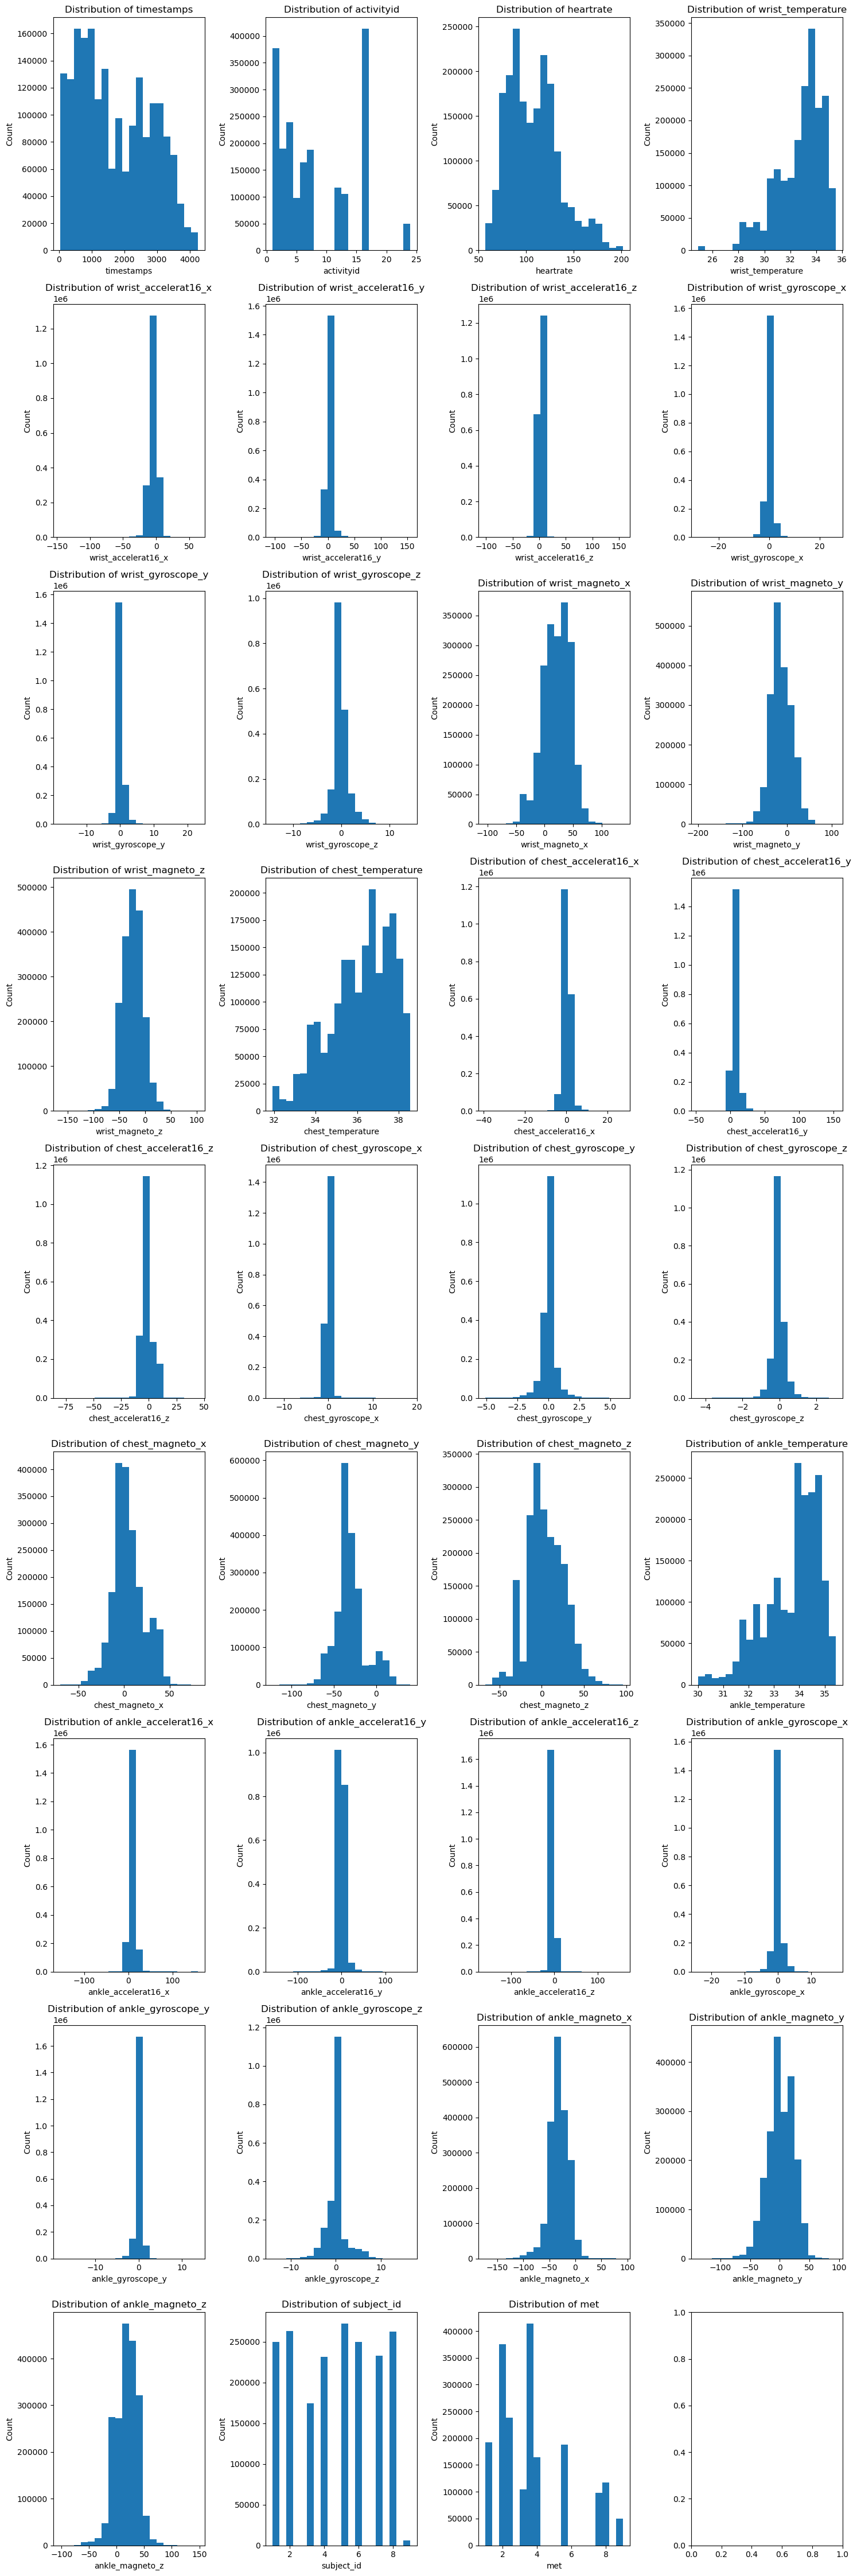

In [36]:
import math
# 'col' is a list of column names containing numerical data
numerical_cols = [col_name for col_name in main_ds.columns if main_ds[col_name].dtype in ['int64', 'float64']]

# Calculate the number of rows and columns needed for subplots
num_cols = 4
num_rows = math.ceil(len(numerical_cols) / num_cols)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Flatten the axes array for ease of iteration
axes = axes.flatten()

# Plot histograms for numerical columns in subplots
for i, col_name in enumerate(numerical_cols):
    axes[i].hist(main_ds[col_name], bins=20)
    axes[i].set_title(f'Distribution of {col_name}')
    axes[i].set_xlabel(col_name)
    axes[i].set_ylabel('Count')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

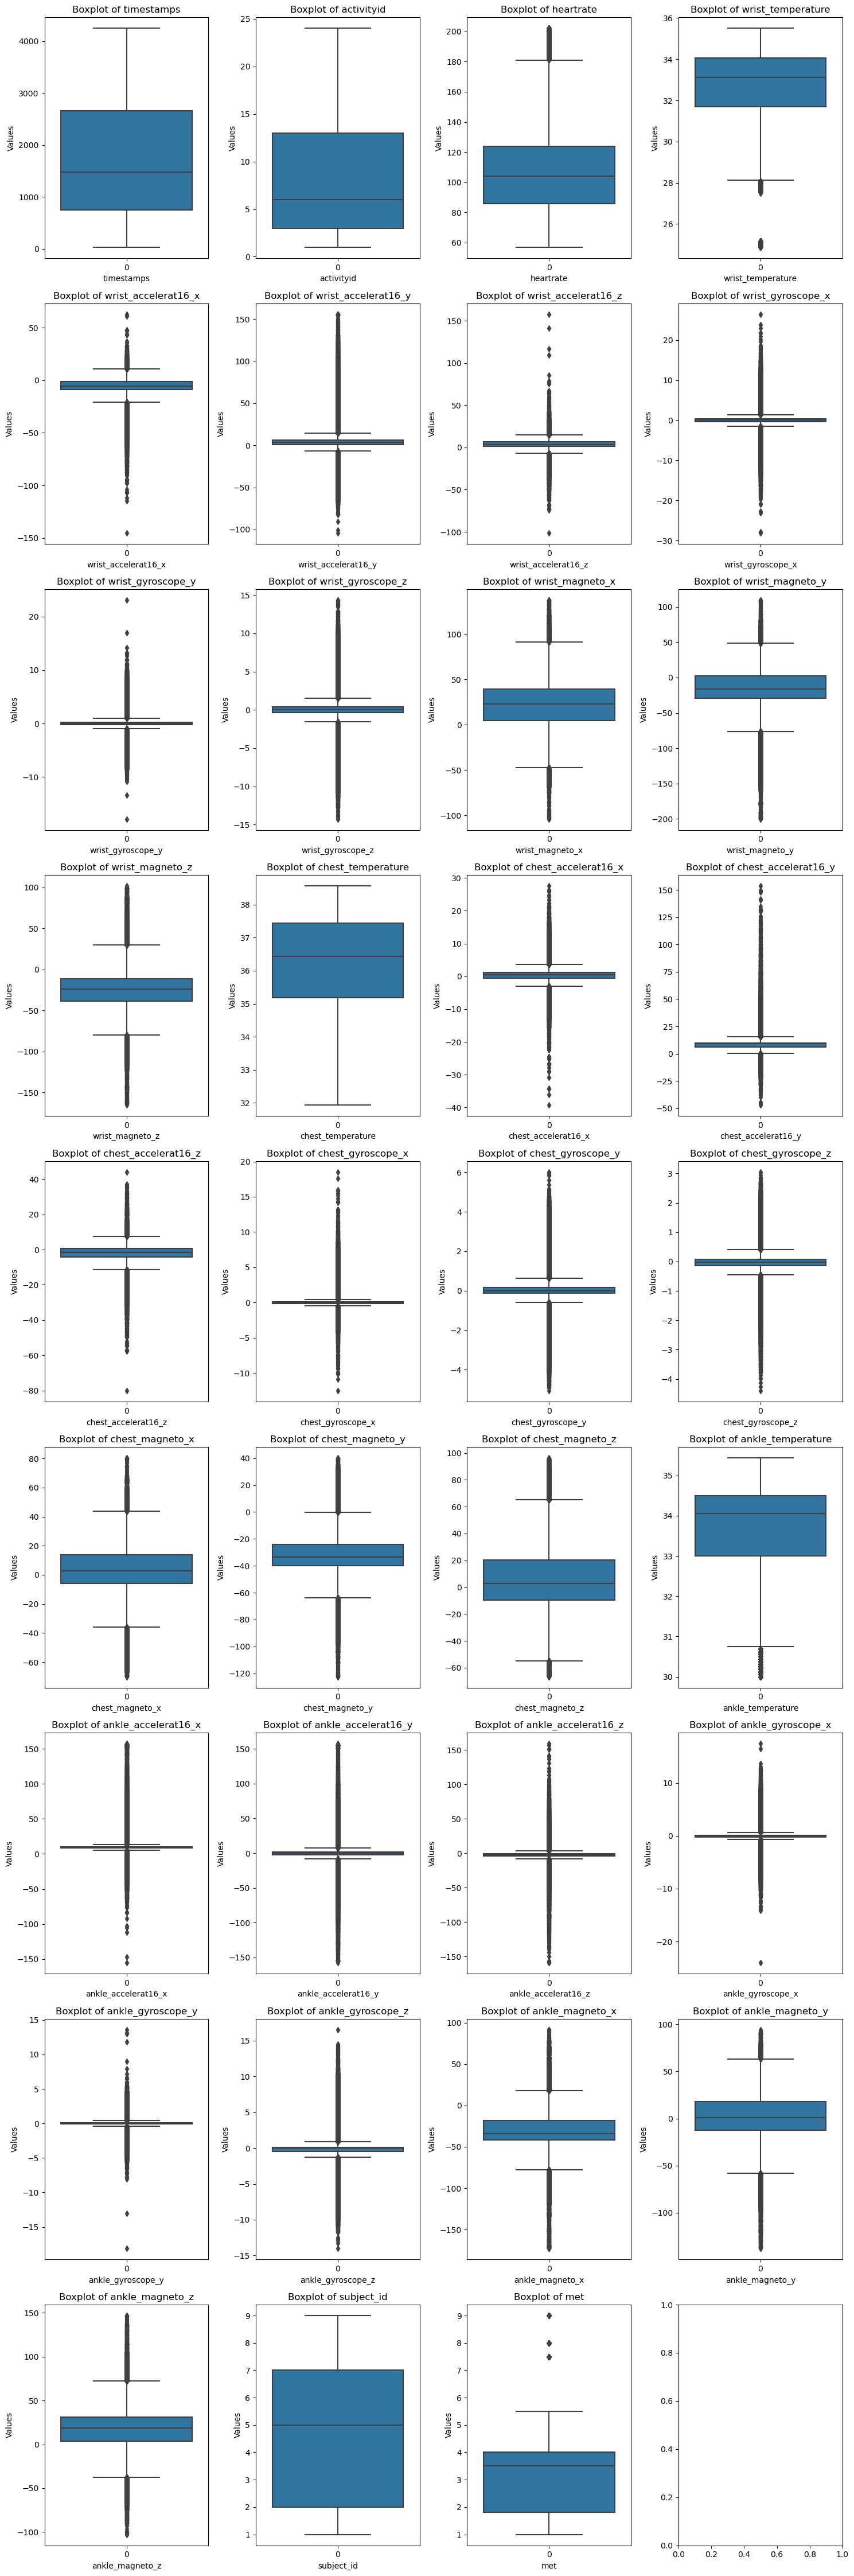

In [37]:
# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Flatten the axes array for ease of iteration
axes = axes.flatten()

# Plot boxplots for numerical columns in subplots
for i, col_name in enumerate(numerical_cols):
    sns.boxplot(main_ds[col_name], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col_name}')
    axes[i].set_xlabel(col_name)
    axes[i].set_ylabel('Values')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

Above boxplot doesnt reveal much of the information as its seen timestamps column has a notably greater range or variance than the other columns, it making it more difficult to see the box plots of the other columns because the size of that column dominates the plot and makes it harder to see features in the smaller-scale columns. The features related to acceleration, gyroscope, magneto are seen with outliers. Below I am trying to further breakdown and understand the relationship between different columns separately.

## Analysis of Target variable: Heartrate

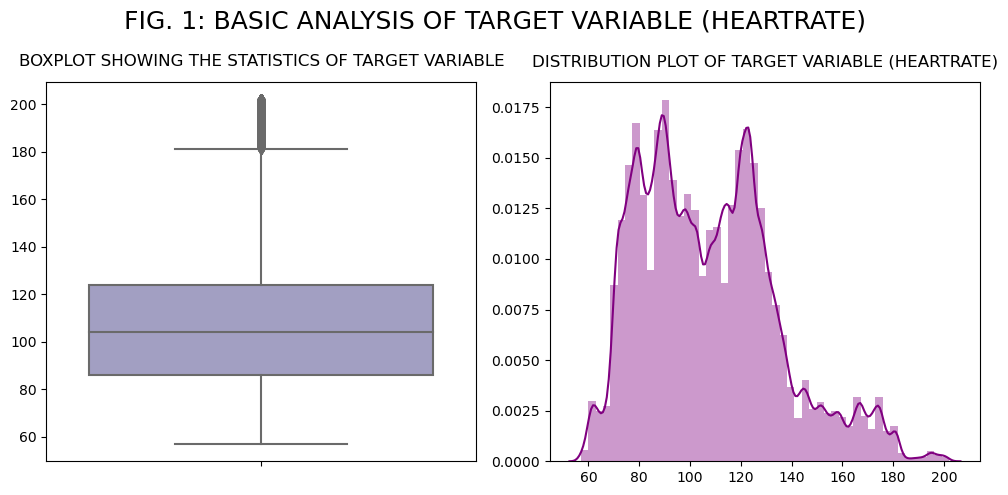

In [38]:
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(10,5))

fig.suptitle('Fig. 1: Basic analysis of target variable (heartrate)'.upper(), fontsize=18)

#Populating plot1
sns.boxplot(y=main_ds['heartrate'], ax=ax[0], palette='Purples')
ax[0].set_title('Boxplot showing the statistics of target variable'.upper(), fontsize=12, fontweight=20, y=1.02)
ax[0].set_ylabel('')
ax[0].set_xlabel('')

#Populating plot2
sns.distplot(main_ds['heartrate'], ax=ax[1], color='purple')
ax[1].set_title('Distribution plot of target variable (heartrate)'.upper(), fontsize=12, fontweight=20, y=1.02)
ax[1].set_ylabel('')
ax[1].set_xlabel('')

#setting aesthetics
plt.tight_layout()
plt.show()

### Observations

1. Q1 of target variable lies around 85 and Q3 at around 125. IQR thus is approximately 40 with median at around 105
2. Target variable shows variable distribution of values with multiple plateaues.

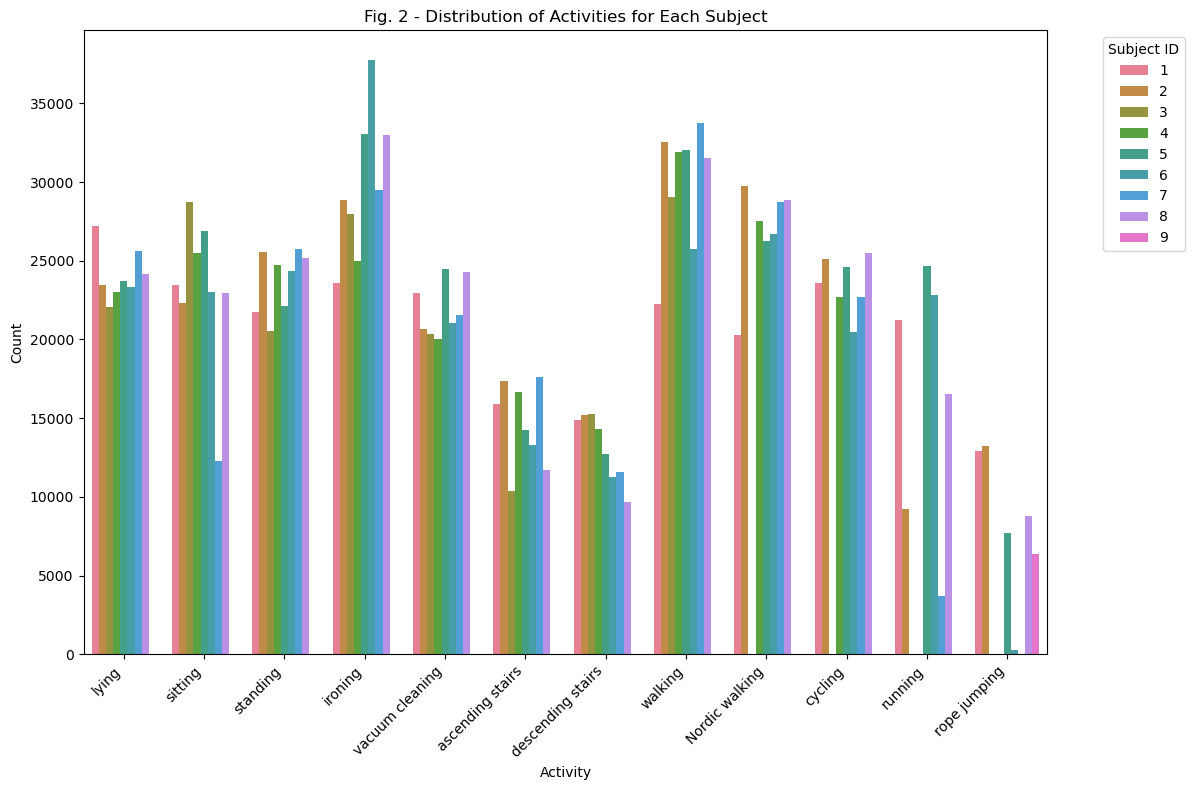

In [39]:
# Assuming your DataFrame is named df_master
plt.figure(figsize=(12, 8))

# Create the countplot
ax = sns.countplot(x='activity', hue='subject_id', data=main_ds, palette='husl')

plt.title('Fig. 2 - Distribution of Activities for Each Subject')
plt.xlabel('Activity')
plt.ylabel('Count')

plt.legend(title='Subject ID', loc='upper right', bbox_to_anchor=(1.15, 1))

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Observations:
The distribution of activities by particular subject is depicted in the plot above. After conducting study findings, it came out that, aside from rope jumping, activities such as climbing and descending stairs had the lowest count. On the other hand, the activity involving ironing had the highest distribution, with subject 6 completing it more frequently than the rest. The activity that has the fewest subjects participating is rope jumping with the least distributuion.

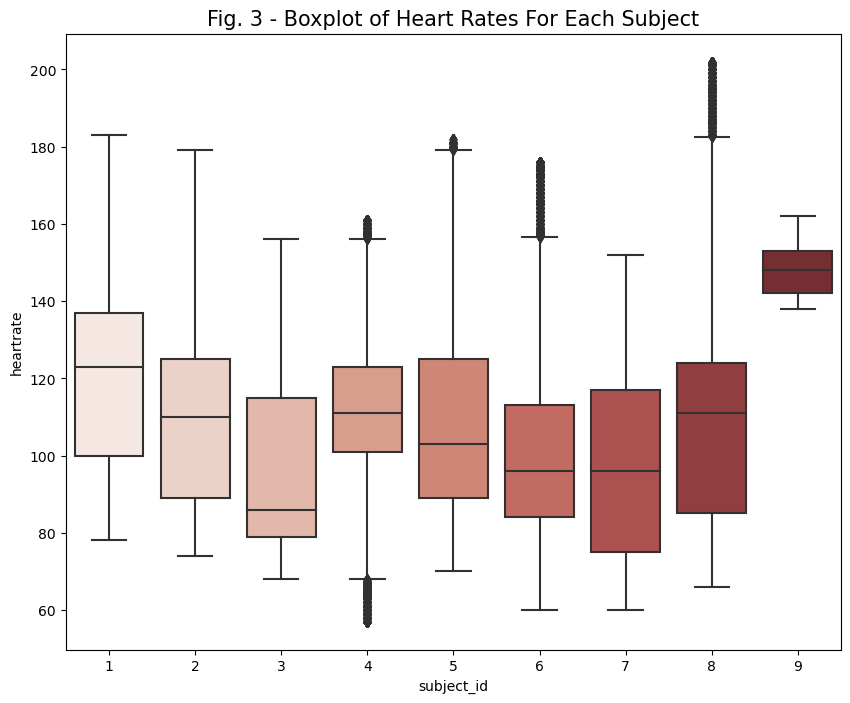

In [40]:
# Set the figure size
plt.figure(figsize=(10, 8))

# Create a box plot using Seaborn
sns.boxplot(x='subject_id', y='heartrate', data=main_ds, palette='Reds', saturation=0.5, whis=1.5)

# Set the title for the plot
plt.title("Fig. 3 - Boxplot of Heart Rates For Each Subject", fontsize=15)

# Show the plot
plt.show()

Fig. 3 boxplot represents heartrate of all subjects across every activity.

### Observations:
Among every subject, subject 9 has a very small range in heartrate. As seen in Fig 2, subject 9 performed only one activity i.e. rope jumping so there is very less data which is not the case in others.

Subject 7 is having a symmetrical distrbution, meanwhile subject 3, given that the tail extends towards higher values and more data points are concentrated on the lower end, the distribution may be positively skewed.

Subject 4 is having a symmetrical distribution with some outliers present.

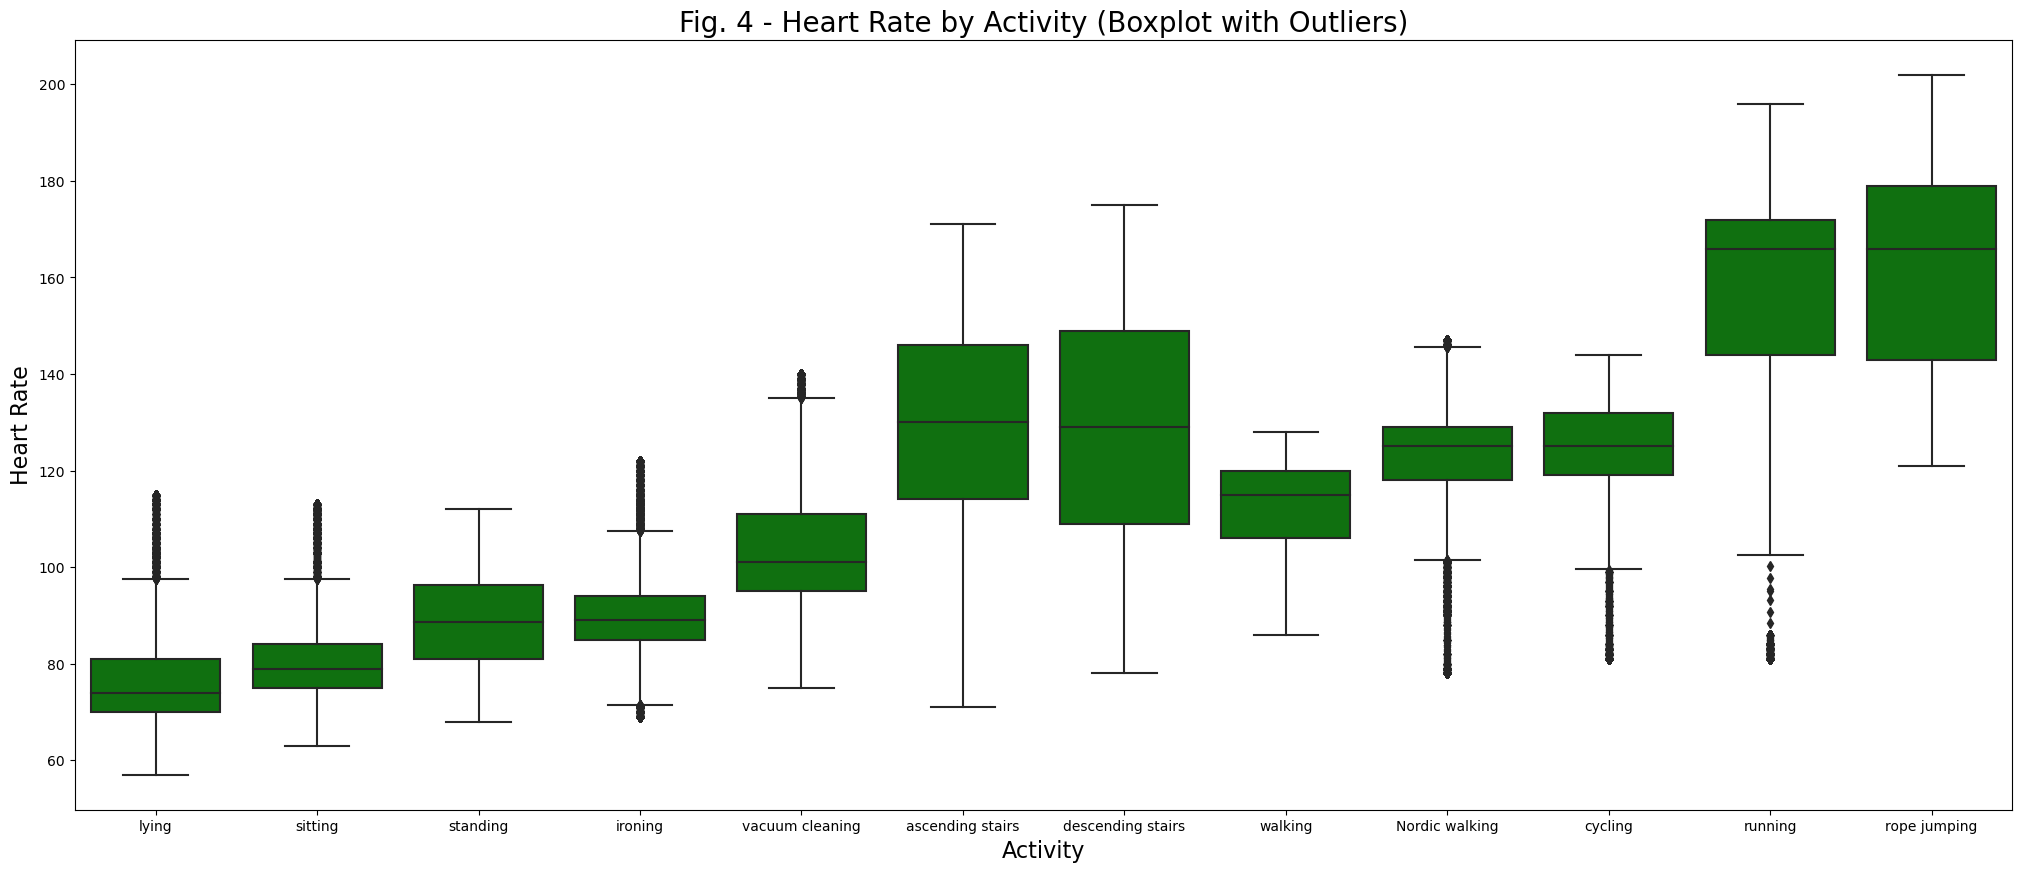

In [41]:
# Subplot 1: Box plot for Heart Rate by activity with outliers (color: green)
fig1, ax1 = plt.subplots(figsize=(25, 10))
sns.boxplot(x="activity", y="heartrate", data=main_ds, showfliers=True, ax=ax1, color='green')
ax1.set_title('Fig. 4 - Heart Rate by Activity (Boxplot with Outliers)', fontsize=20)
ax1.set_xlabel('Activity', fontsize=16)
ax1.set_ylabel('Heart Rate', fontsize=16)
plt.show()

### Observations: 
The above boxplot depicts heartrate by activity with presence of outliers. The plot represents normal distribution, positively skew and negatively skew. The activities ascending stairs, descending stairs, standing, and cycling showing a normal distribution while lying, vaccum cleaning are rightly skewed since its closed to lower values showing positive skew. The activities rope jumping, running, Nordic walking, walking having left-skew distribution.

Text(0, 0.5, 'Frequency')

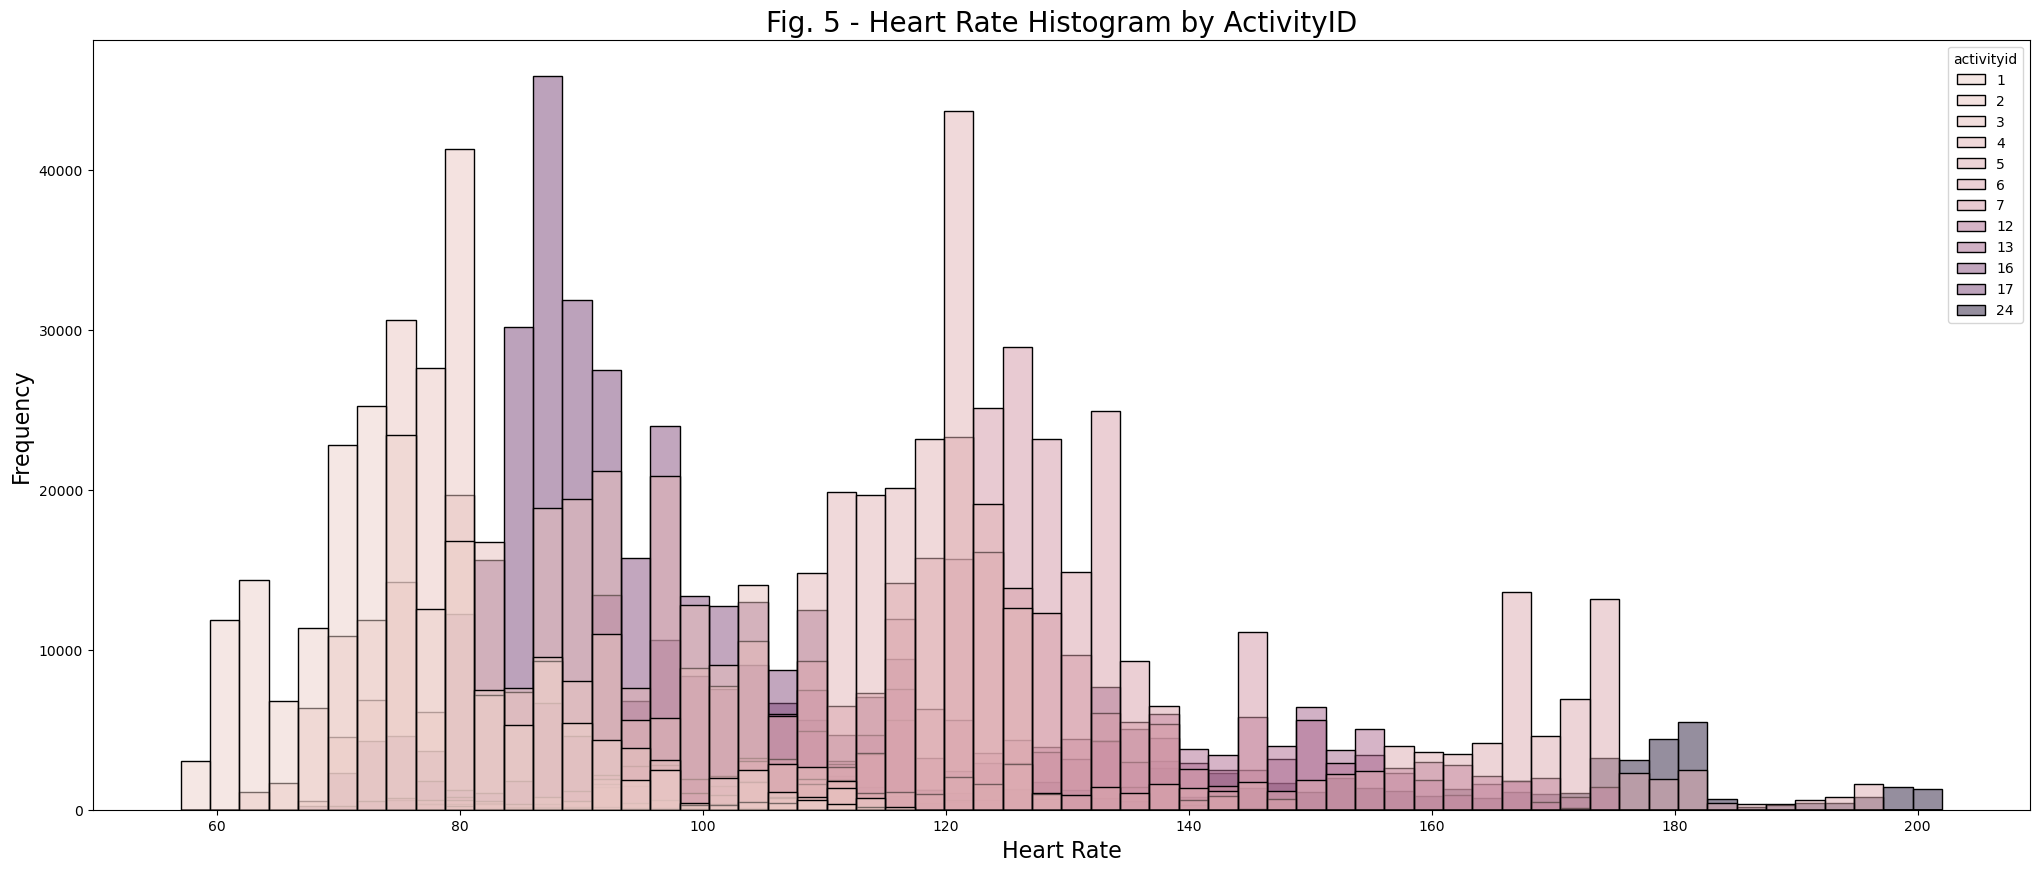

In [42]:
# Subplot 2: Histogram for Heart Rate by activityid (color: red)
fig2, ax2 = plt.subplots(figsize=(25, 10))
histplot1 = sns.histplot(main_ds, x="heartrate", bins=60, hue='activityid', ax=ax2, color='red')
ax2.set_title('Fig. 5 - Heart Rate Histogram by ActivityID', fontsize=20)
ax2.set_xlabel('Heart Rate', fontsize=16)
ax2.set_ylabel('Frequency', fontsize=16)

Text(0, 0.5, 'Frequency')

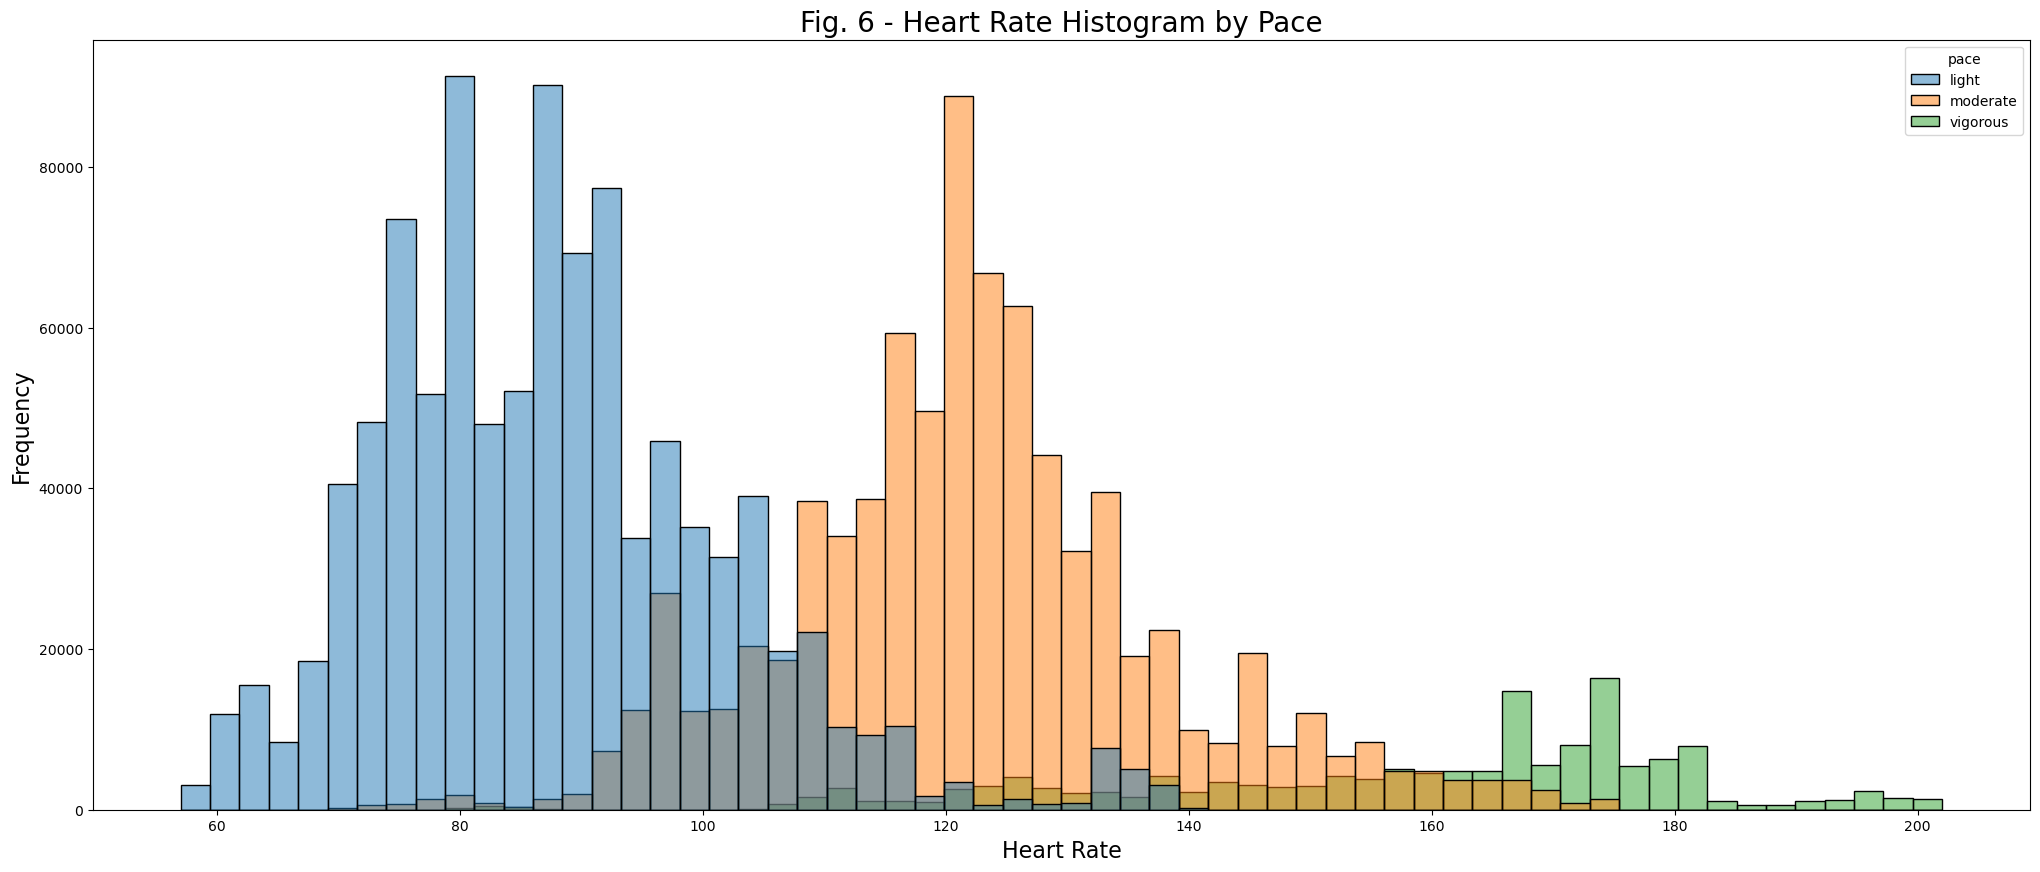

In [43]:
# Subplot 3: Histogram for Heart Rate by pace (color: blue)
fig2, ax2 = plt.subplots(figsize=(25, 10))
histplot1 = sns.histplot(main_ds, x="heartrate", bins=60, hue='pace', ax=ax2, color='blue')
ax2.set_title('Fig. 6 - Heart Rate Histogram by Pace', fontsize=20)
ax2.set_xlabel('Heart Rate', fontsize=16)
ax2.set_ylabel('Frequency', fontsize=16)

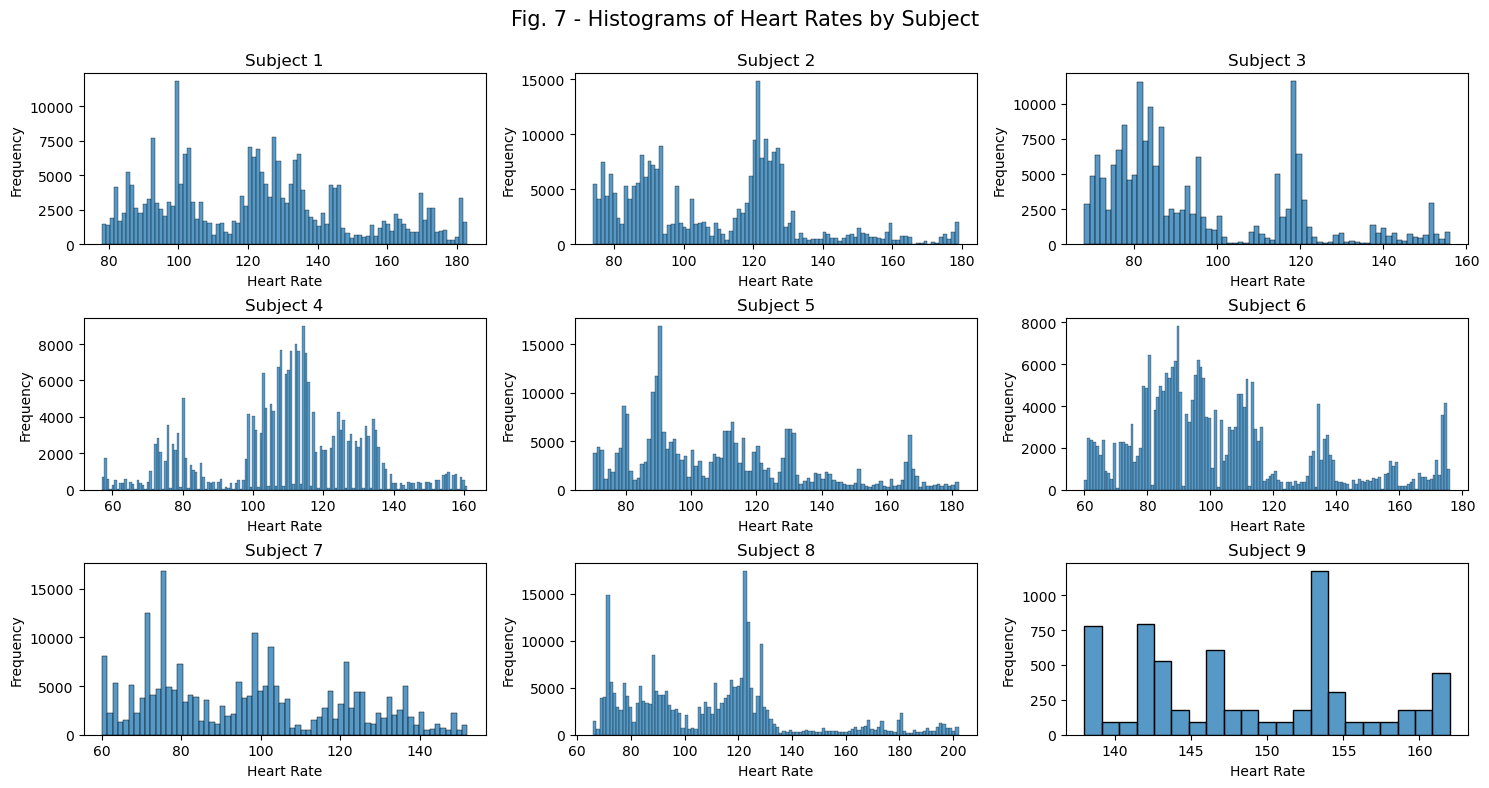

In [44]:
# Get unique subjects
unique_subjects = main_ds['subject_id'].unique()

# Calculate the number of rows and columns based on the number of unique subjects
num_rows = (len(unique_subjects) + 2) // 3  # 3 columns
num_cols = min(3, len(unique_subjects))  # Maximum 3 columns

# Create subplots with dynamically calculated number of rows and columns
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 8))

# Flatten the axes array to iterate over them
axes = axes.flatten()

# Iterate over subjects and plot histograms
for i, subject in enumerate(unique_subjects):
    sns.histplot(main_ds[main_ds['subject_id'] == subject]['heartrate'], ax=axes[i], kde=False)
    axes[i].set_title(f'Subject {subject}')
    axes[i].set_xlabel('Heart Rate')
    axes[i].set_ylabel('Frequency')

# Adjust layout and show the plot
plt.tight_layout()
plt.suptitle('Fig. 7 - Histograms of Heart Rates by Subject', fontsize=15)
plt.subplots_adjust(top=0.9)
plt.show()

Furthermore, we plot an average heart rate over time (timestamp) considering all activities & subjects.

## Analysis in terms of timestamps

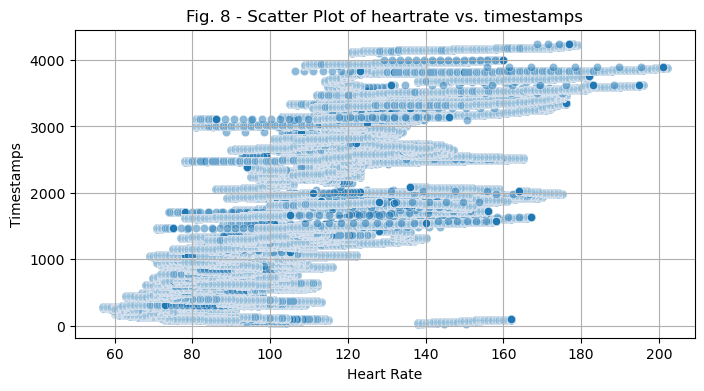

In [45]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x='heartrate', y='timestamps', data=main_ds, alpha=0.5)
plt.title('Fig. 8 - Scatter Plot of heartrate vs. timestamps')
plt.xlabel('Heart Rate')
plt.ylabel('Timestamps')
plt.grid(True)
plt.show()

### Observations

This graph makes it quite evident that there is a strong linear relationship between heartrate and timestamps.

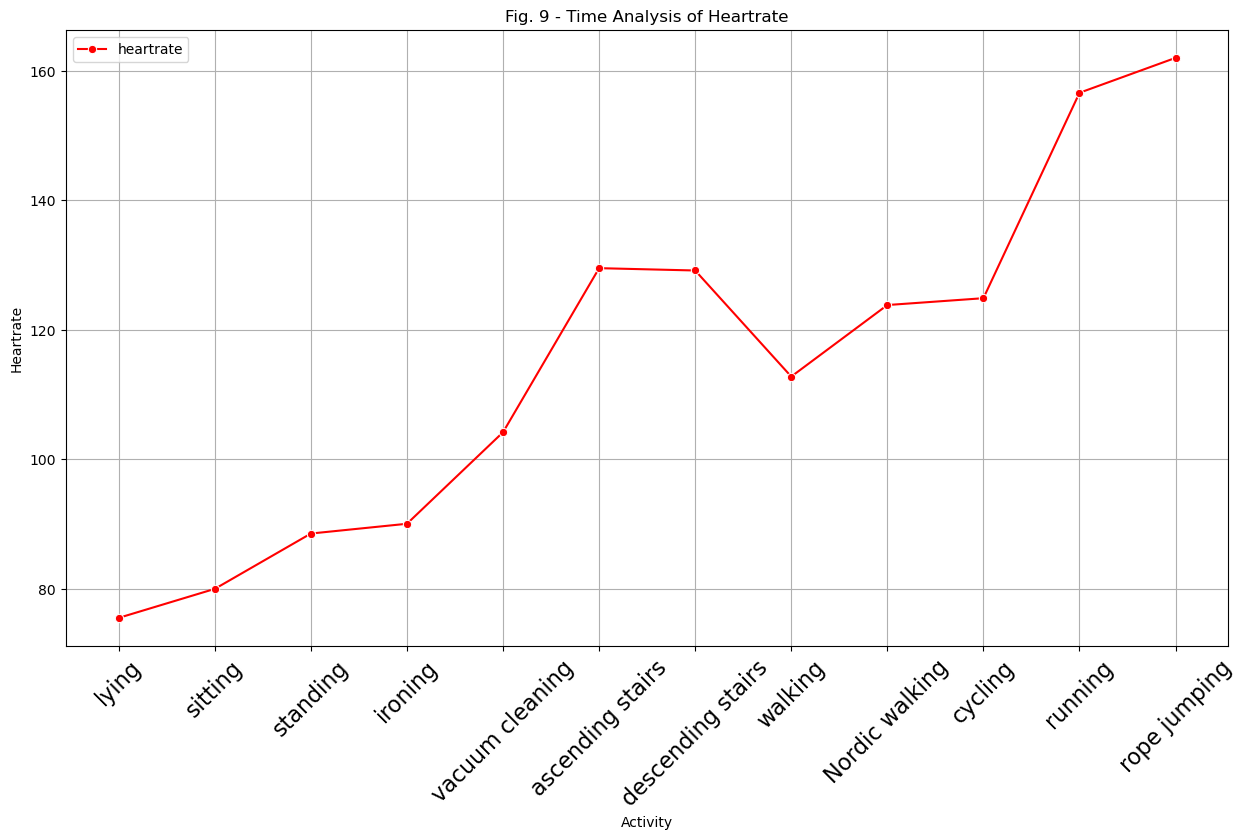

In [46]:
# Plot heartrate against timestamps  plot
plt.figure(figsize=(15, 8))
sns.lineplot(x="activity", y="heartrate", data=main_ds, marker='o', ci=None, label='heartrate', color='red')
plt.title('Fig. 9 - Time Analysis of Heartrate')
plt.xlabel('Activity')
plt.ylabel('Heartrate')
plt.grid(True)
plt.xticks(fontsize=16, rotation=45)  # Increase x-axis tick font size and rotate labels
plt.show()

Running and rope jumping activities have the highest heart rates, according to the line plot above.

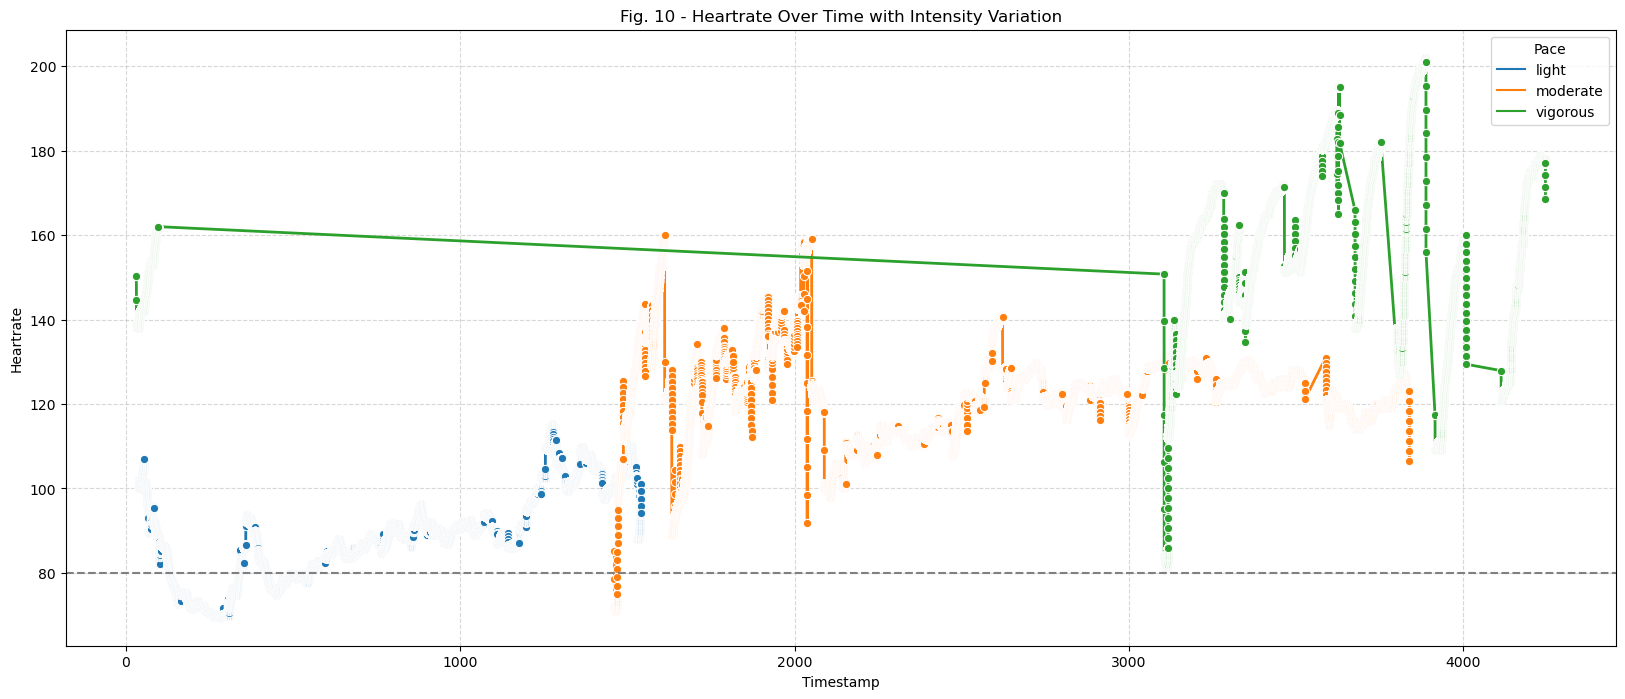

In [47]:
# Create a line plot with timestamp on the x-axis, heartrate on the y-axis, and color-coded by intensity
plt.figure(figsize=(20, 8))
sns.lineplot(x="timestamps", y="heartrate", data=main_ds, ci=None, color='red', hue='pace', marker='o', linestyle='-', linewidth=2)

# Add title and labels to the plot
plt.title("Fig. 10 - Heartrate Over Time with Intensity Variation")
plt.xlabel("Timestamp")
plt.ylabel("Heartrate")

# Display the legend
plt.legend(title='Pace')

# Customize the grid and background
plt.grid(True, linestyle='--', alpha=0.5)
plt.axhline(y=80, color='gray', linestyle='--', label='Threshold')

# Show the plot
plt.show()                                                                

From above plot its clearly evident as the pace increases there is a increase in heartrate
 
Heart rates for low, medium, and high speeds range from 60 to 115, 70 to 160, and 90 to 200, respectively.

### Analysis in terms of MET

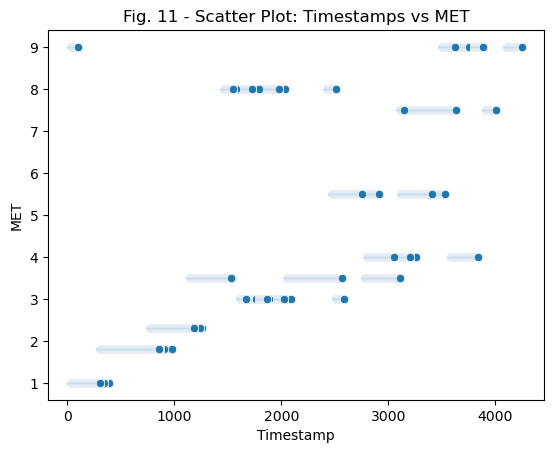

In [48]:
met_timestamp_activity = main_ds[['timestamps', 'activity', 'met']]
grouped_data = met_timestamp_activity.groupby('activity').agg({'met': 'mean', 'timestamps': 'mean'}).reset_index()

correlation = met_timestamp_activity['timestamps'].corr(met_timestamp_activity['met'])

# Scatter plot to visualize the correlation
sns.scatterplot(x='timestamps', y='met', data=met_timestamp_activity)
plt.title('Fig. 11 - Scatter Plot: Timestamps vs MET')
plt.xlabel('Timestamp')
plt.ylabel('MET')
plt.show()

From the Above scatterplot, its strongly evident that timestamp and met has strong relationship

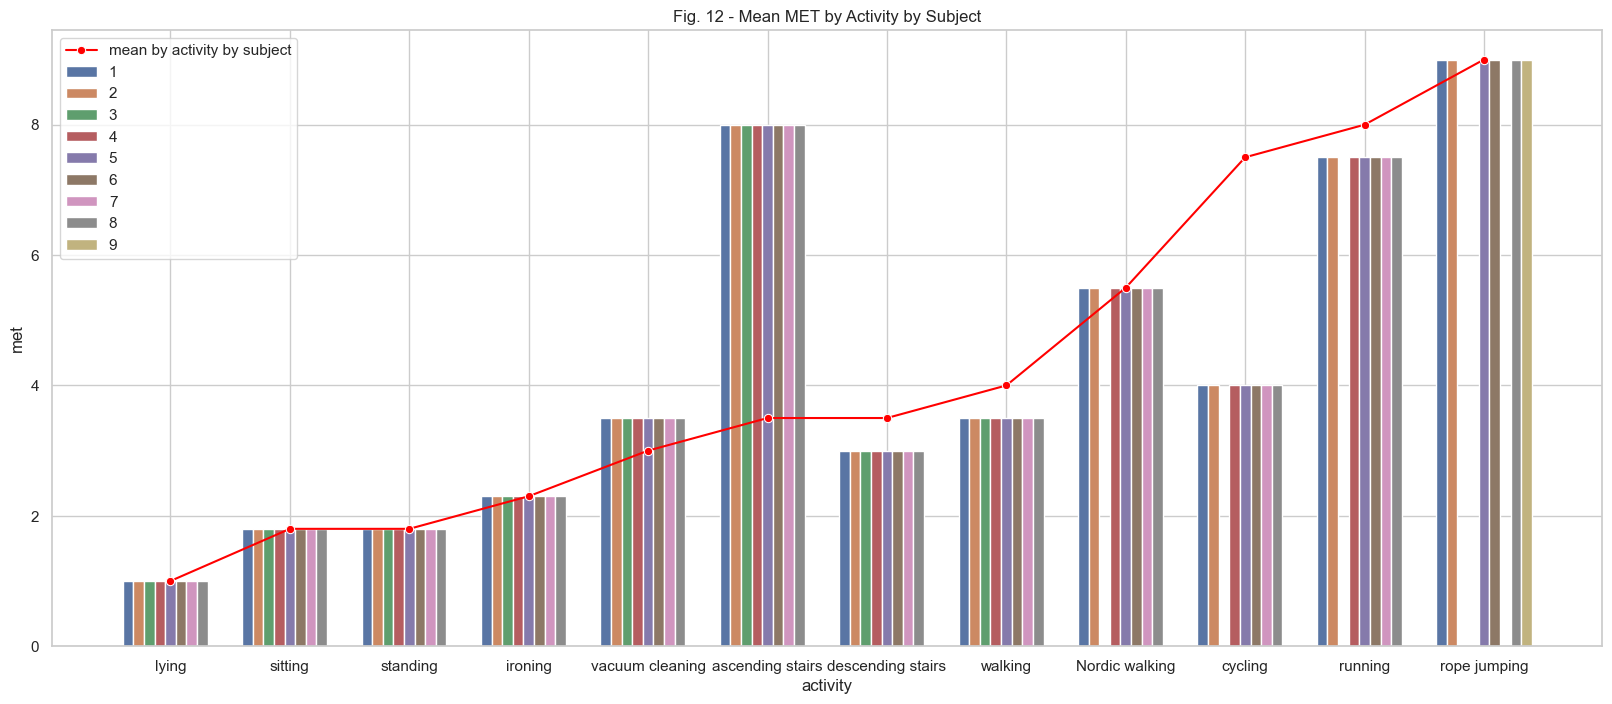

In [49]:
result_met = main_ds.groupby(['subject_id', 'activity']).agg({'met': 'mean'})
result_met = result_met.groupby('activity').agg({'met': 'mean'}).sort_values('met', ascending=True)

plt.figure(figsize=(20, 8)) 
sns.set_theme(style="whitegrid")
sns.barplot(data=main_ds, x="activity", y="met", hue="subject_id")
sns.lineplot(x="activity", y="met", data=result_met, ci=None, color='red', label='mean by activity by subject', marker="o")
plt.title("Fig. 12 - Mean MET by Activity by Subject")
plt.grid(True)
plt.show()

### Analysis in terms of Temperatures

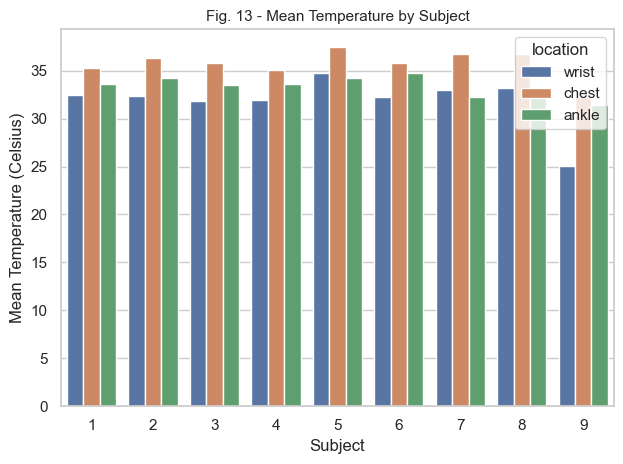

In [50]:
# Aggregate mean temperatures
wrist_temp = main_ds.groupby('subject_id')['wrist_temperature'].mean() 
chest_temp = main_ds.groupby('subject_id')['chest_temperature'].mean()
ankle_temp = main_ds.groupby('subject_id')['ankle_temperature'].mean()

# Combine into single dataframe
temp_means = pd.DataFrame({'wrist': wrist_temp, 
                           'chest': chest_temp,
                           'ankle': ankle_temp})

# Melt to univariate  
temp_melted = temp_means.reset_index().melt(id_vars='subject_id', var_name='location', value_name='temperature')

# Plot
sns.barplot(x='subject_id', y='temperature', hue='location', data=temp_melted)
plt.title('Fig. 13 - Mean Temperature by Subject', fontsize=11)
plt.xlabel('Subject')
plt.ylabel('Mean Temperature (Celsius)')

plt.tight_layout()
plt.show()

### Observations:
All the subjects has a high temperature where the sensor is close to their chest, as seen in the barplot above. With the exception of subjects 5 and 9, whose hand temperatures are somewhat higher and lower, respectively, as all subjects' temperatures in all three locations differ very little.

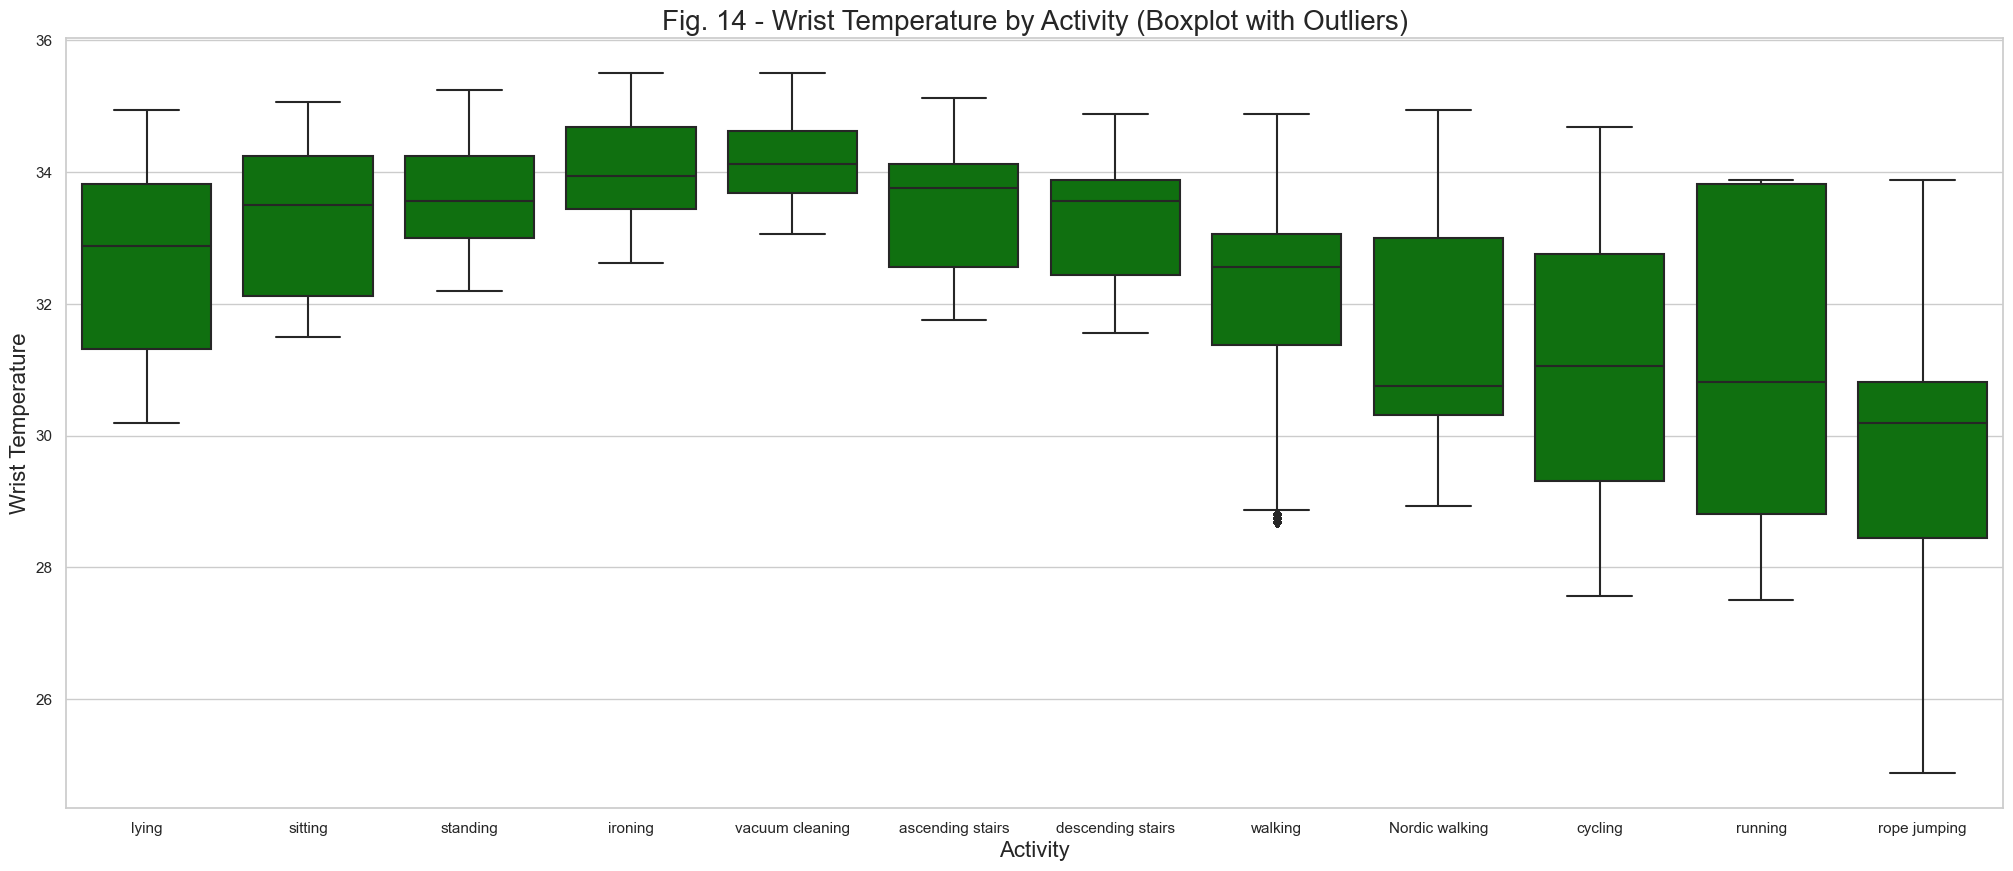

In [51]:
# Subplot 1: Box plot for Wrist Temperature by activity with outliers (color: green)
fig1, ax1 = plt.subplots(figsize=(25, 10))
sns.boxplot(x="activity", y="wrist_temperature", data=main_ds, showfliers=True, ax=ax1, color='green')
ax1.set_title('Fig. 14 - Wrist Temperature by Activity (Boxplot with Outliers)', fontsize=20)
ax1.set_xlabel('Activity', fontsize=16)
ax1.set_ylabel('Wrist Temperature', fontsize=16)
plt.show()

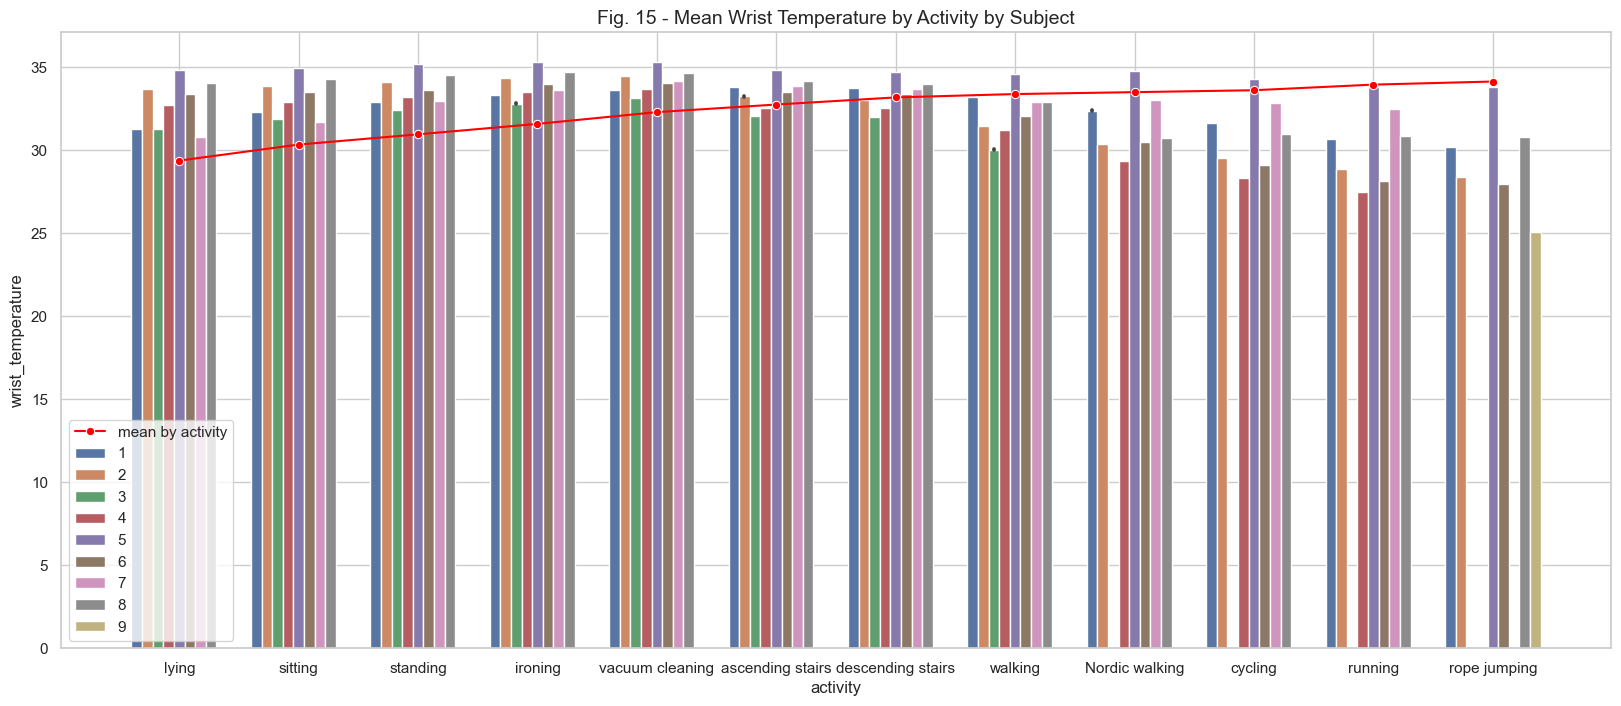

In [52]:
result_temp_wrist = main_ds.groupby(['subject_id', 'activity']).agg({'wrist_temperature': 'mean'})
result_temp_wrist = result_temp_wrist.groupby('activity').agg({'wrist_temperature': 'mean'}).sort_values('wrist_temperature', ascending=True)

plt.figure(figsize=(20, 8))
sns.set_theme(style="whitegrid")
sns.barplot(data=main_ds, x="activity", y="wrist_temperature", hue="subject_id")
sns.lineplot(x="activity", y="wrist_temperature", data=result_temp_wrist, ci=None, color='red', label='mean by activity', marker="o")
plt.title("Fig. 15 - Mean Wrist Temperature by Activity by Subject", fontsize=14)

plt.grid(True)
plt.show()

The barplot above confirms that, in comparison to the other subjects, subject 5 has a high wrist temperature. The ironing and vacuuming activities have been associated with high temperatures, which makes sense given that the supplies for these tasks are hot and operated by hand. Moreover, the sensors are located close to them.

Text(0, 0.5, 'Frequency')

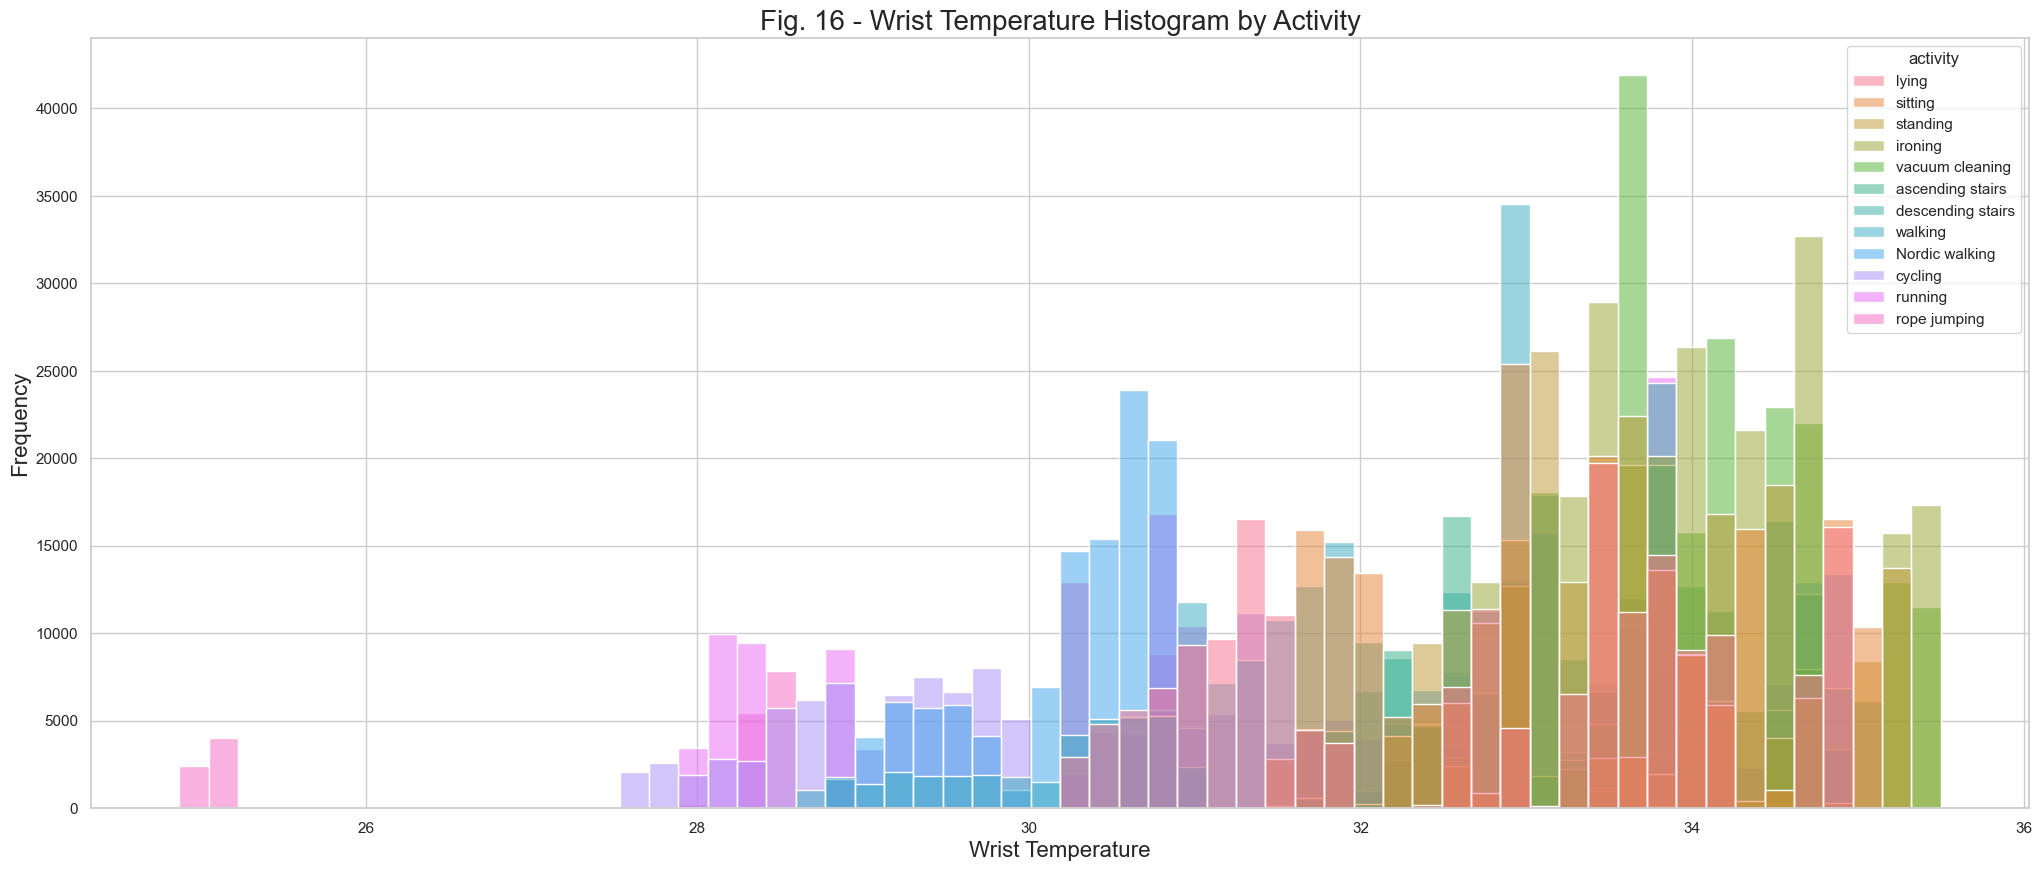

In [53]:
# Subplot 2: Histogram for Wrist Temperature by activity (color: red)
fig2, ax2 = plt.subplots(figsize=(25, 10))
histplot1 = sns.histplot(main_ds, x="wrist_temperature", bins=60, hue='activity', ax=ax2, color='red')
ax2.set_title('Fig. 16 - Wrist Temperature Histogram by Activity', fontsize=20)
ax2.set_xlabel('Wrist Temperature', fontsize=16)
ax2.set_ylabel('Frequency', fontsize=16)

Text(0, 0.5, 'Frequency')

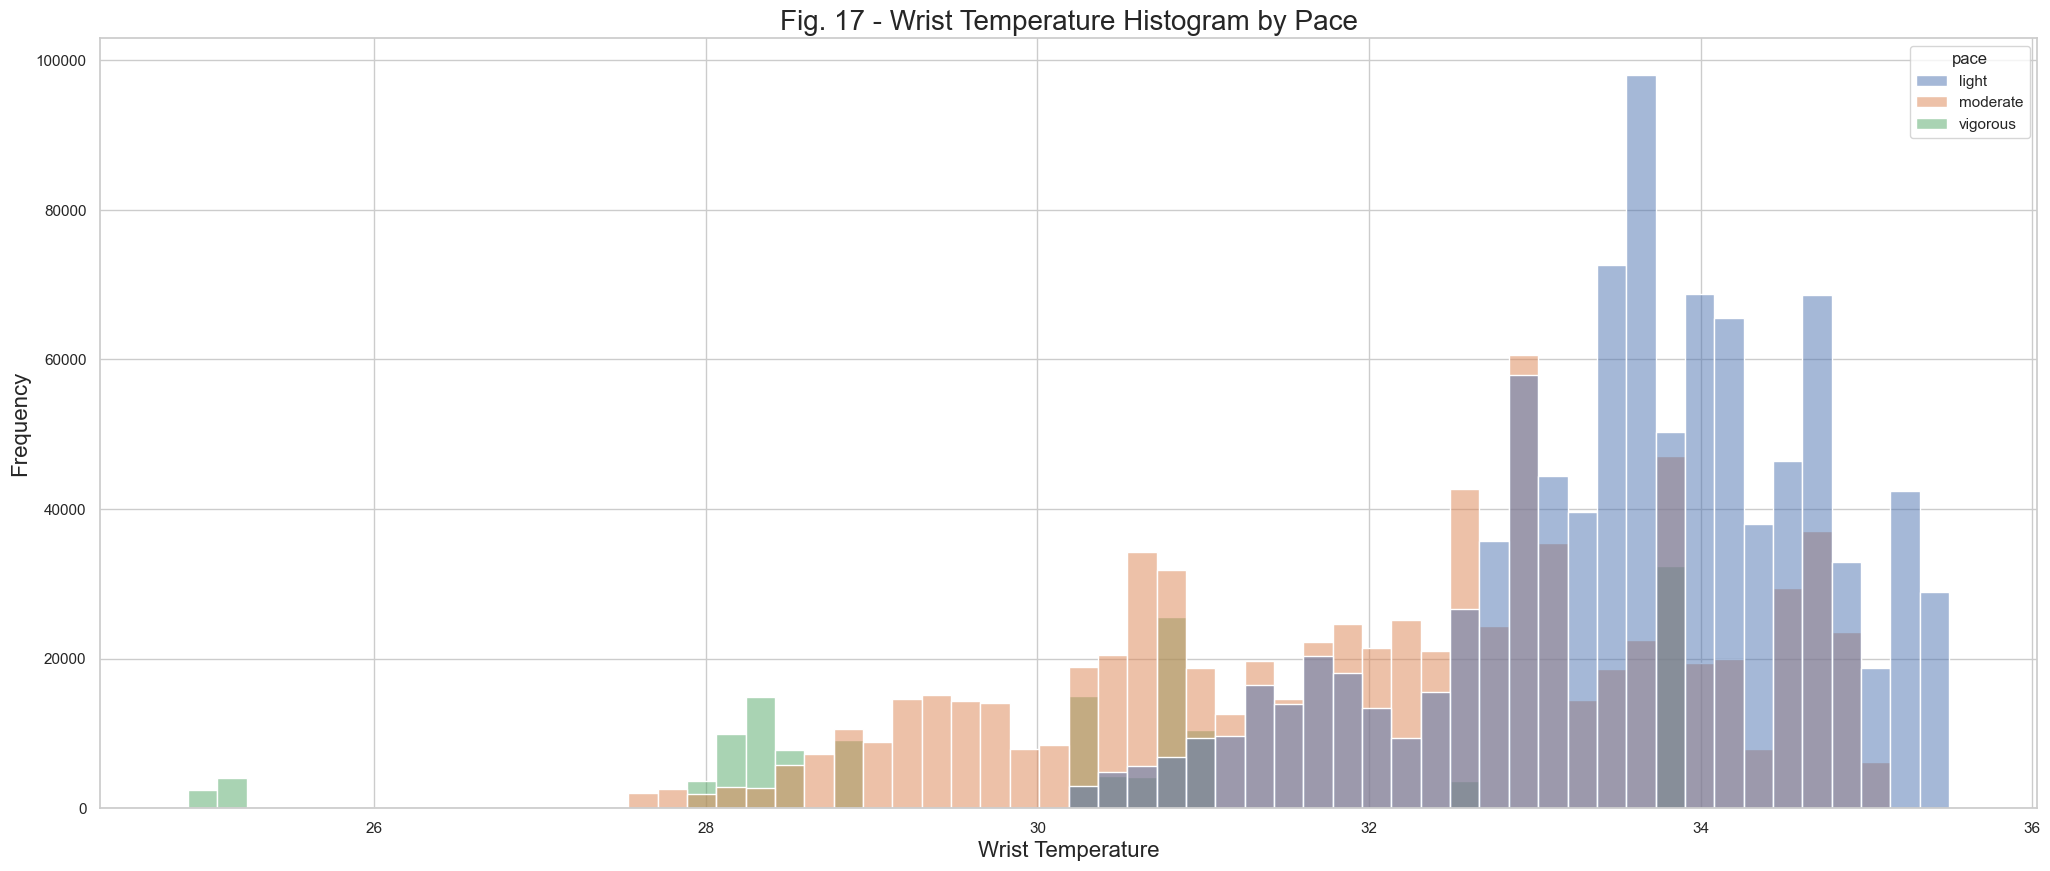

In [54]:
# Subplot 2: Histogram for Wrist Temperature by Pace (color: blue)
fig2, ax2 = plt.subplots(figsize=(25, 10))
histplot1 = sns.histplot(main_ds, x="wrist_temperature", bins=60, hue='pace', ax=ax2, color='blue')
ax2.set_title('Fig. 17 - Wrist Temperature Histogram by Pace', fontsize=20)
ax2.set_xlabel('Wrist Temperature', fontsize=16)
ax2.set_ylabel('Frequency', fontsize=16)

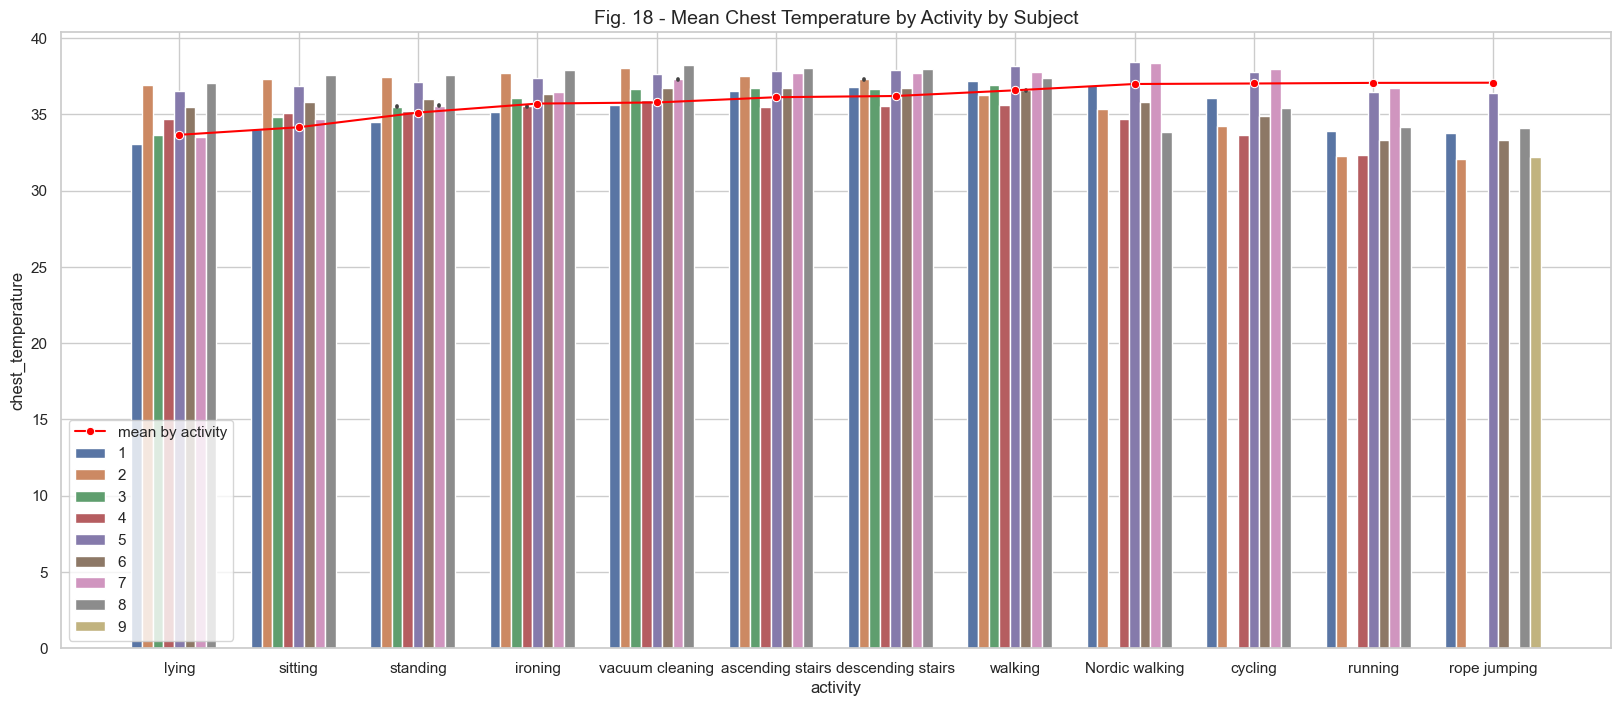

In [55]:
result_temp = main_ds.groupby(['subject_id', 'activity']).agg({'chest_temperature': 'mean'})
result_temp = result_temp.groupby('activity').agg({'chest_temperature': 'mean'}).sort_values('chest_temperature', ascending=True)

plt.figure(figsize=(20, 8))
sns.set_theme(style="whitegrid")
sns.barplot(data=main_ds, x="activity", y="chest_temperature", hue="subject_id")
sns.lineplot(x="activity", y="chest_temperature", data=result_temp, ci=None, color='red', label='mean by activity', marker="o")
plt.title("Fig. 18 - Mean Chest Temperature by Activity by Subject", fontsize=14)
plt.grid(True)
plt.show()

The highest recorded chest temperatures were found in Subjects 2 and 8, when they were lying, sitting, standing, ironing, and vacuum-cleaning. Subject 2's temperature decreased during all other activities, however Subject 8's temperature remained high during activities involving climbing and descending stairs. Following this, Subjects 5 and 7 gained the upper hand with a higher  chest temperature of around 37.

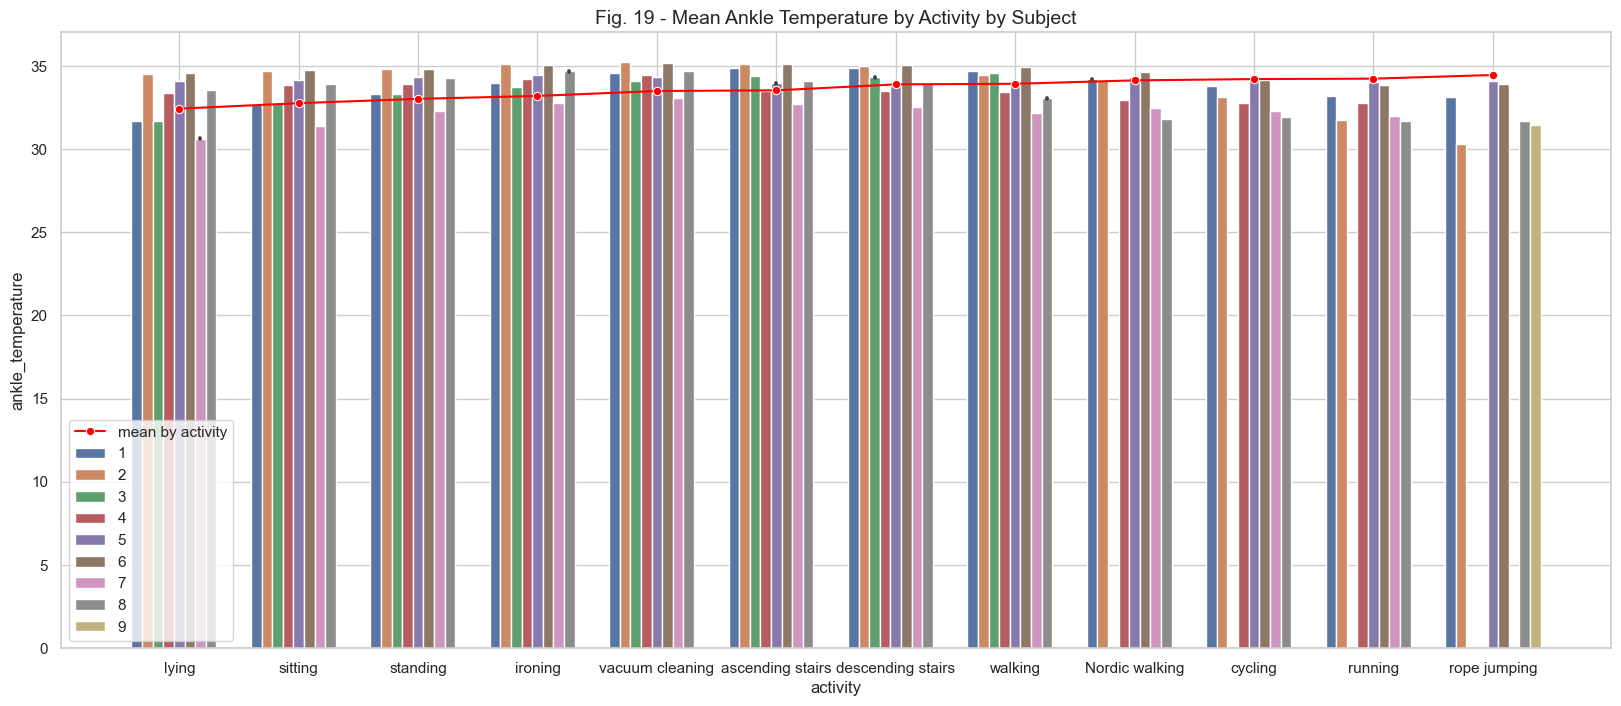

In [56]:
result_temp_ankle = main_ds.groupby(['subject_id', 'activity']).agg({'ankle_temperature': 'mean'})
result_temp_ankle = result_temp_ankle.groupby('activity').agg({'ankle_temperature': 'mean'}).sort_values('ankle_temperature', ascending=True)

plt.figure(figsize=(20, 8))
sns.set_theme(style="whitegrid")
sns.barplot(data=main_ds, x="activity", y="ankle_temperature", hue="subject_id")
sns.lineplot(x="activity", y="ankle_temperature", data=result_temp_ankle, ci=None, color='red', label='mean by activity', marker="o")
plt.title("Fig. 19 - Mean Ankle Temperature by Activity by Subject", fontsize=14)

plt.grid(True)
plt.show()

## Intervariable relationships using heatmap

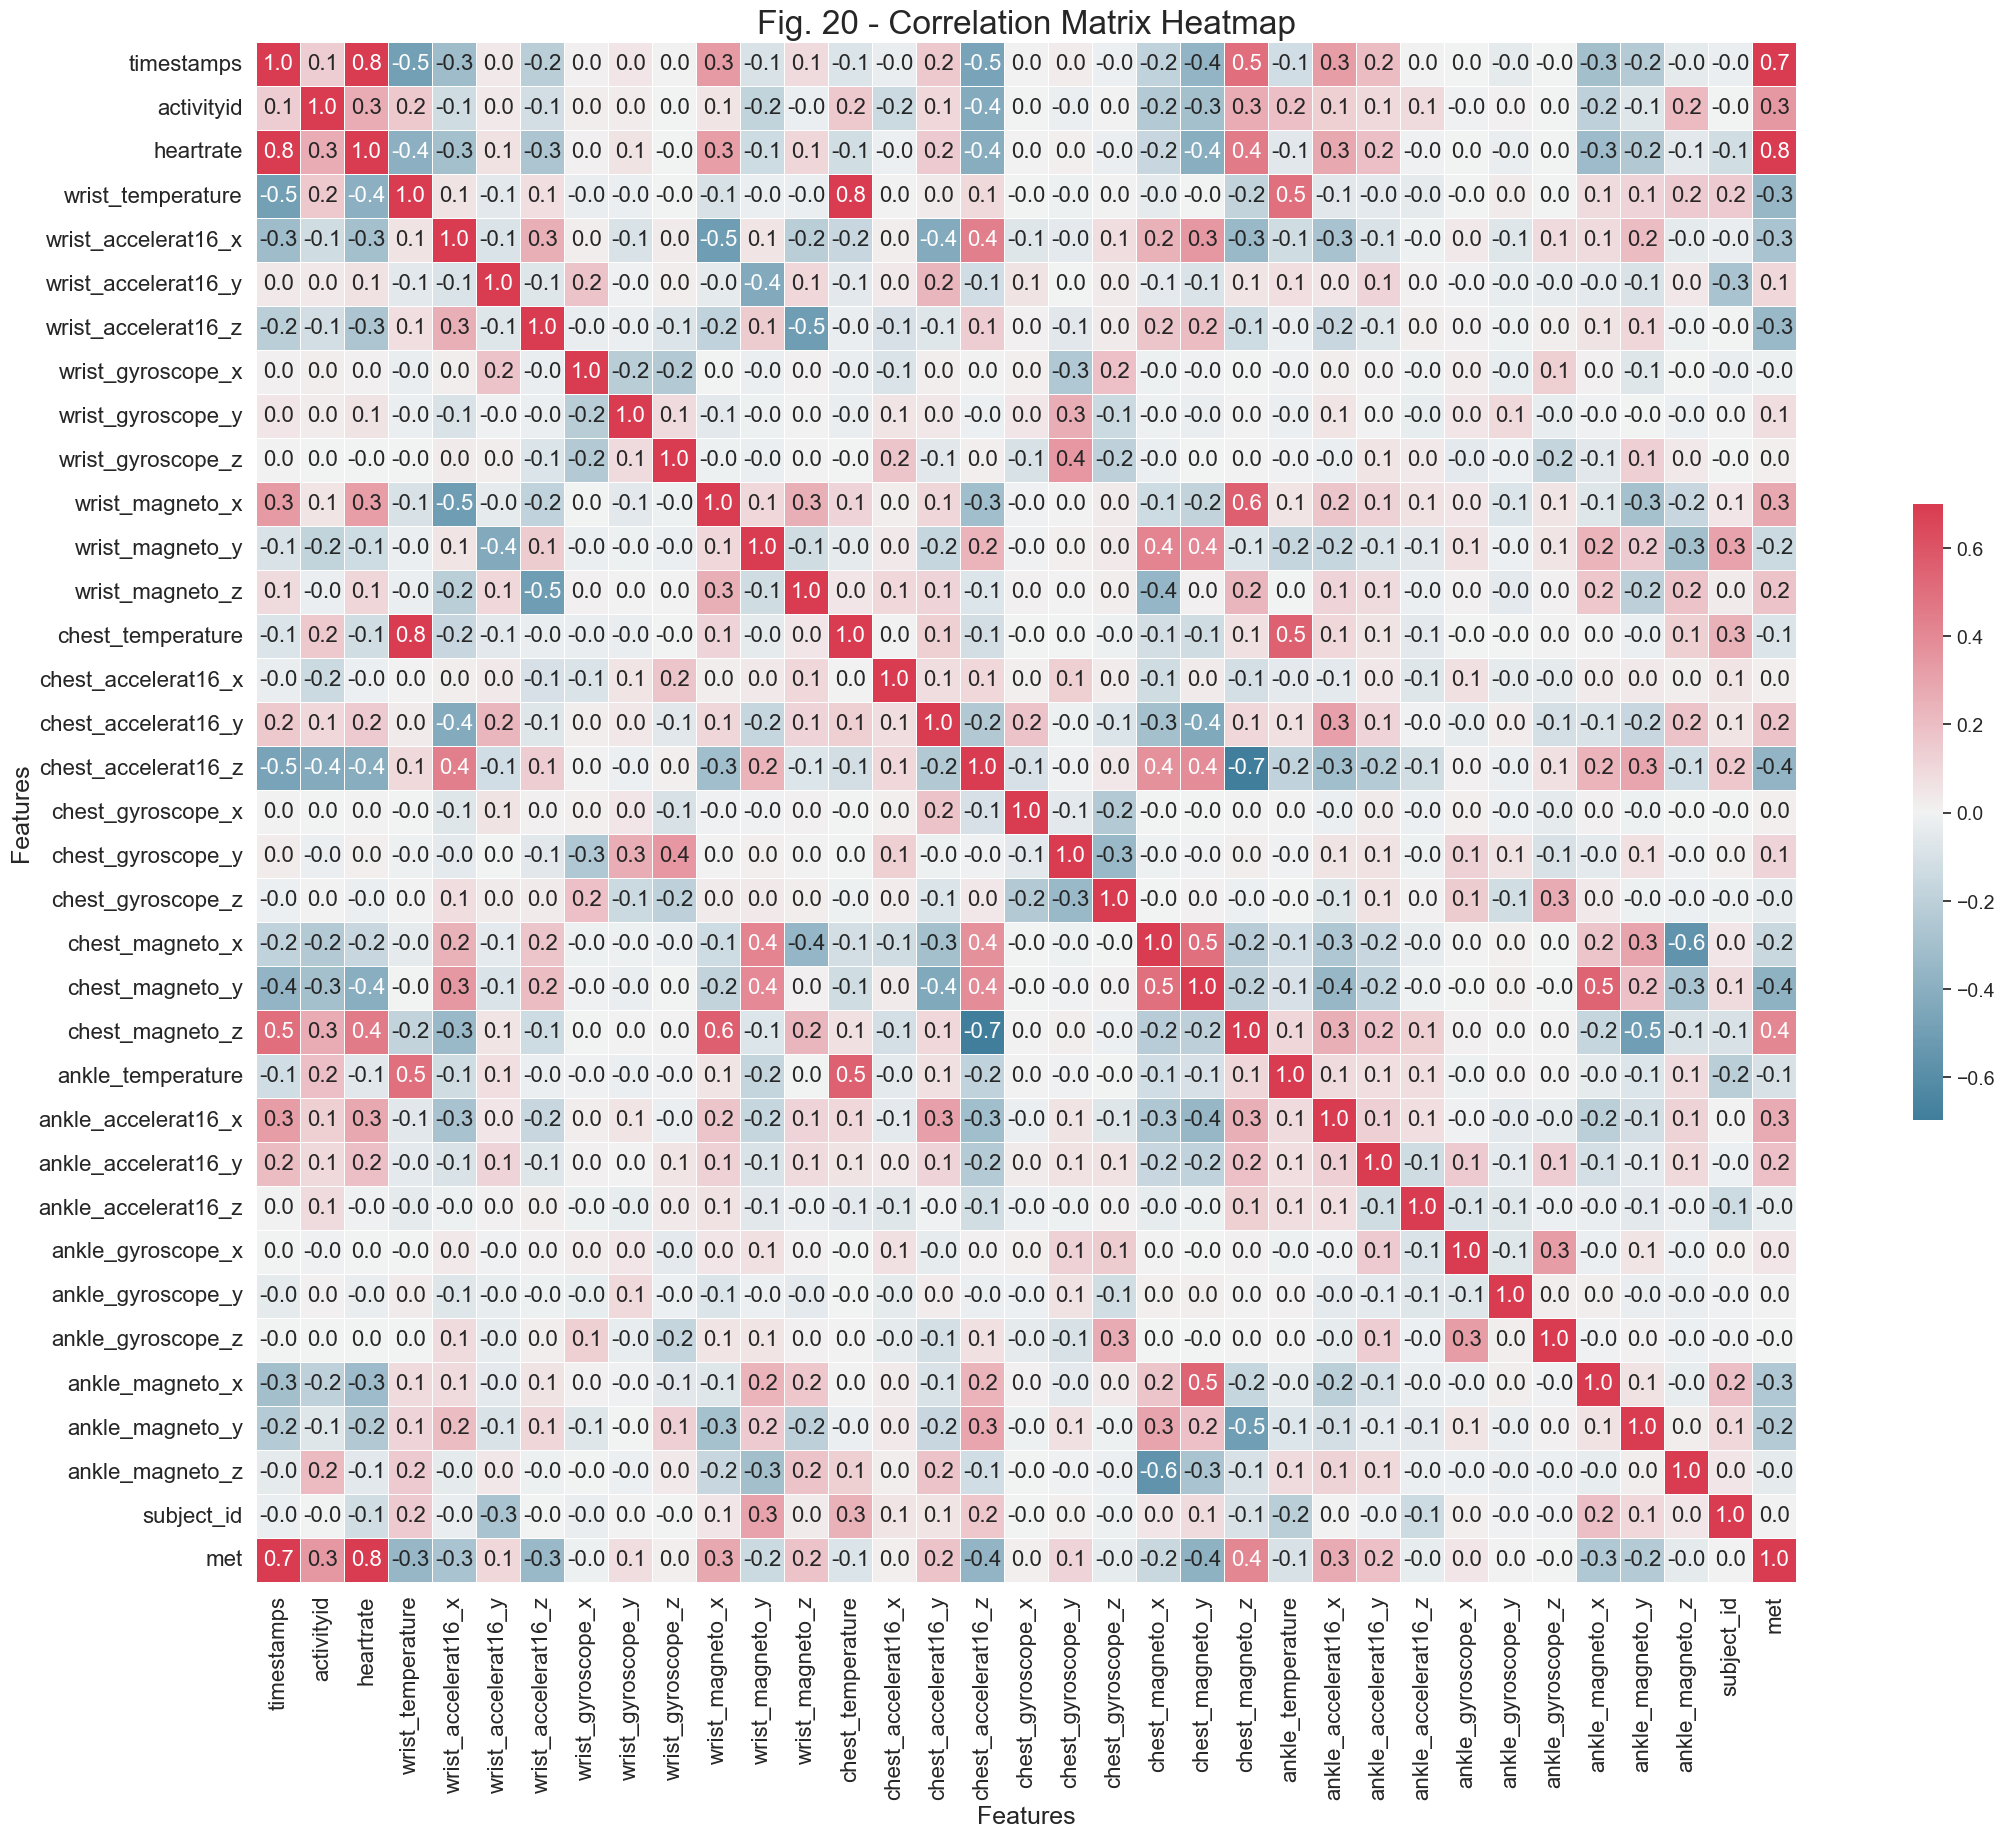

In [57]:
numeric_columns = main_ds.select_dtypes(include=[np.number])
corr_spearman = numeric_columns.corr()
# Set up the matplotlib figure with an increased size
plt.figure(figsize=(30, 20))

# Generate a custom diverging color palette for the heatmap
cmap = sns.diverging_palette(230, 8, as_cmap=True)

# Draw the heatmap with the specified settings
ax = sns.heatmap(corr_spearman, cmap=cmap, vmax=0.7, center=0,
                 square=True, linewidths=.5, cbar_kws={"shrink": .4}, 
                 annot=True, fmt='.1f', annot_kws={"size": 16})  # Increase font size to 16

# Additional customization for better readability and interpretation
plt.title("Fig. 20 - Correlation Matrix Heatmap", fontsize=24)  # Increase title font size
plt.xlabel("Features", fontsize=18)  # Increase x-axis label font size
plt.ylabel("Features", fontsize=18)  # Increase y-axis label font size
plt.xticks(fontsize=16, rotation=90)  # Increase x-axis tick font size and rotate labels
plt.yticks(fontsize=16)  # Increase y-axis tick font size

# Add a colorbar legend for reference
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)  # Increase colorbar tick font size

plt.show()

### Observations:

Since heartrate is my primary concern, I'm examining which columns have a correlation with heartrate.

The correlation matrix shows us what we can see below.
1) The variable heartrate chest_magneto_z have a medium positive correlation of 0.4.
2) heartrate and wrist_temperature have a medium-negative correlation of 0.4.
3) heartrate and chest_accelerat16_z have a 0.4 medium-negative correlation.
5) heartrate and the variable chest_magneto_y have a medium-negative correlation (0.4).
6) heartrate and the variable wrist_accelerat16_x have a moderately negative correlation of 0.3.
8) heartrate and the variable wrist_accelerat16_z have a moderately negative correlation of 0.3.
11) The variable ankle_magneto_x and heartrate have a medium-negative correlation of 0.3.
12) heartrate and the variable wrist_magneto_x have a 0.3 medium positive correlation.
13) heartrate and the variable ankle_accelerat16_x have a moderately positive correlation of 0.3 .
15) The variable chest_temperature and wrist_temperature, heartrate and timestamps, and met have one of the strongest correlations of 0.8.
16) The variable wrist_magneto_x and chest_magneto_z have a strong positive correlation of 0.6

Let us examine more closely.

The following plot displays some of the variables that have the strongest correlation.

In [58]:
# Assuming your DataFrame is named df
correlation_matrix = main_ds.corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                     timestamps  activityid  heartrate  wrist_temperature  \
timestamps             1.000000    0.143712   0.781775          -0.493668   
activityid             0.143712    1.000000   0.265381           0.159361   
heartrate              0.781775    0.265381   1.000000          -0.395946   
wrist_temperature     -0.493668    0.159361  -0.395946           1.000000   
wrist_accelerat16_x   -0.321946   -0.129910  -0.298461           0.059135   
wrist_accelerat16_y    0.039313    0.038607   0.065738          -0.053282   
wrist_accelerat16_z   -0.215711   -0.116732  -0.268301           0.077814   
wrist_gyroscope_x      0.011050    0.019514   0.012267          -0.025622   
wrist_gyroscope_y      0.047300    0.027951   0.059772          -0.023345   
wrist_gyroscope_z      0.002810    0.001211  -0.001140          -0.001049   
wrist_magneto_x        0.337554    0.053006   0.322638          -0.096724   
wrist_magneto_y       -0.095913   -0.188853  -0.134858  

In [59]:
# Assuming you want correlations with the 'target_column'
correlations_with_target = correlation_matrix['heartrate']

# Print the correlations with the target column
print("Correlations with the target column:")
print(correlations_with_target)

Correlations with the target column:
timestamps             0.781775
activityid             0.265381
heartrate              1.000000
wrist_temperature     -0.395946
wrist_accelerat16_x   -0.298461
wrist_accelerat16_y    0.065738
wrist_accelerat16_z   -0.268301
wrist_gyroscope_x      0.012267
wrist_gyroscope_y      0.059772
wrist_gyroscope_z     -0.001140
wrist_magneto_x        0.322638
wrist_magneto_y       -0.134858
wrist_magneto_z        0.106774
chest_temperature     -0.127351
chest_accelerat16_x   -0.018568
chest_accelerat16_y    0.151209
chest_accelerat16_z   -0.409820
chest_gyroscope_x      0.007119
chest_gyroscope_y      0.016382
chest_gyroscope_z     -0.021718
chest_magneto_x       -0.157433
chest_magneto_y       -0.403926
chest_magneto_z        0.449635
ankle_temperature     -0.062199
ankle_accelerat16_x    0.283513
ankle_accelerat16_y    0.193730
ankle_accelerat16_z   -0.004173
ankle_gyroscope_x      0.001234
ankle_gyroscope_y     -0.028446
ankle_gyroscope_z      0.001555
ank

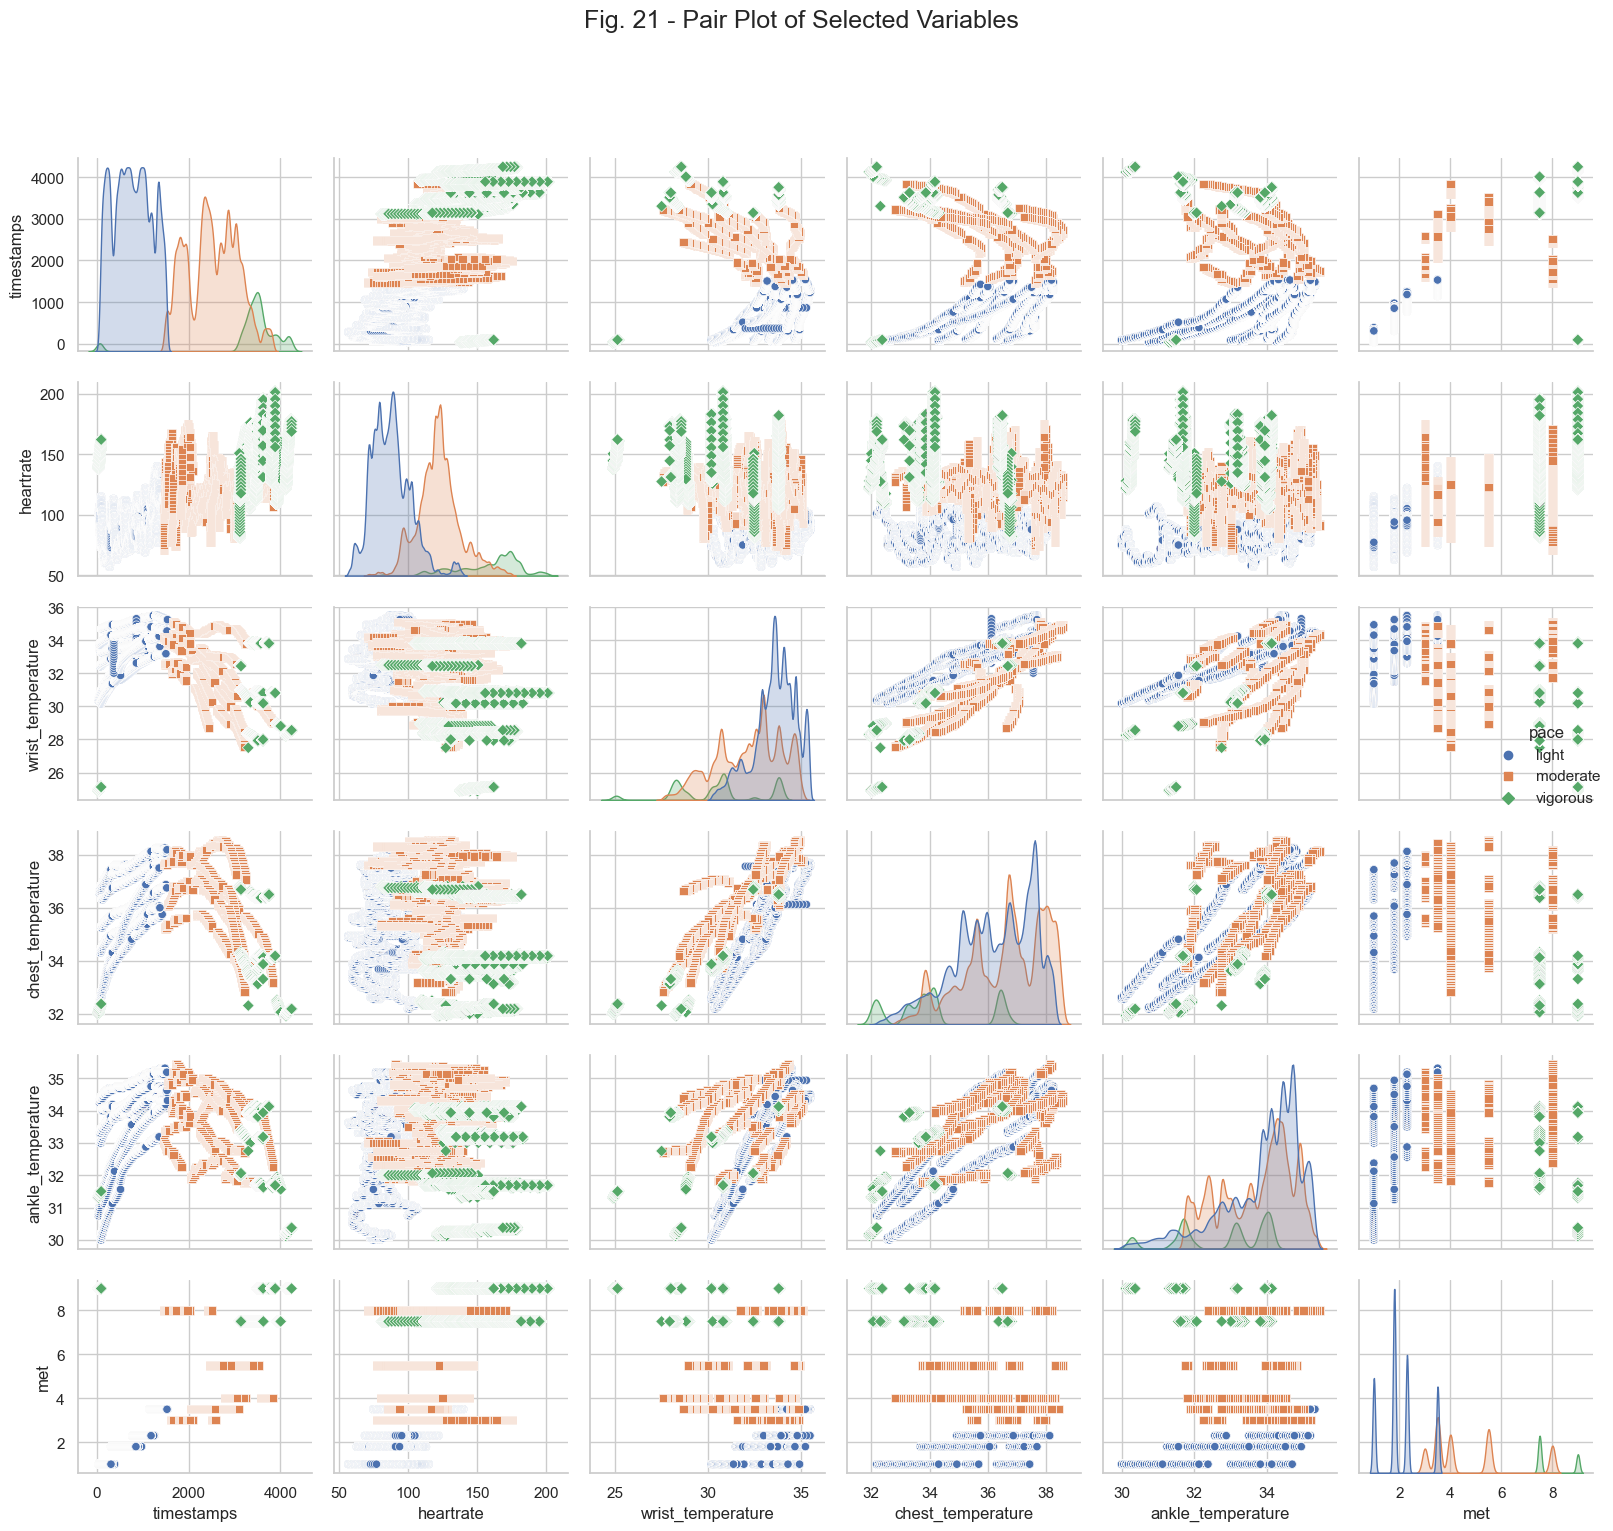

In [60]:
# Set the style
sns.set(style="whitegrid")
 
# Create the pa ir plot
plot = sns.pairplot(main_ds, vars=['timestamps', 'heartrate', 'wrist_temperature', 'chest_temperature',
                                  'ankle_temperature', 'met'], 
                    hue='pace', markers=["o", "s", "D"], diag_kind='kde')
   
# Customize the plot appearance
plot.fig.suptitle("Fig. 21 - Pair Plot of Selected Variables", y=1.02, size=18)
plot.fig.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to avoid title overlap

# Show the plot 
plt.show()

This above pairplot shows strong relationship between chest_temperature and wrist temperature, ankle_temperature and chest_temperature and timestamps and heartrate. Lets check on the skewness of the dataframe as well.

In [61]:
# Calculate skewness for all columns
skewness = main_ds.skew()

# Display skewness for each column
print("Skewness for each column:")
print(skewness)

Skewness for each column:
timestamps             0.296017
activityid             0.697799
heartrate              0.652269
wrist_temperature     -0.959386
wrist_accelerat16_x   -0.481500
wrist_accelerat16_y    2.438045
wrist_accelerat16_z   -0.706527
wrist_gyroscope_x      0.084471
wrist_gyroscope_y      0.598358
wrist_gyroscope_z     -0.181241
wrist_magneto_x       -0.302446
wrist_magneto_y       -0.161420
wrist_magneto_z        0.000734
chest_temperature     -0.568199
chest_accelerat16_x    0.290551
chest_accelerat16_y    1.630368
chest_accelerat16_z    0.348954
chest_gyroscope_x      3.238464
chest_gyroscope_y      0.015733
chest_gyroscope_z     -0.035331
chest_magneto_x        0.270980
chest_magneto_y        0.682366
chest_magneto_z        0.119941
ankle_temperature     -0.888452
ankle_accelerat16_x    2.862256
ankle_accelerat16_y    0.231686
ankle_accelerat16_z   -1.362601
ankle_gyroscope_x      0.195740
ankle_gyroscope_y     -0.999799
ankle_gyroscope_z      0.811730
ankle_magneto_

# Section 2: Linear Regression as a Mathematical Model

A simple and widely used kind of predictive analysis is linear regression.  Regression's main goal is to look at two things:
1) How well can a group of predictor variables predict a dependent variable that is the outcome?  
2) Which specific variables, as shown by the size and sign of the beta estimates, are important predictors of the outcome variable, and how do they affect the outcome variable? 

The link between one dependent variable and one or more independent variables is explained using these regression estimations.

In [62]:
model_df=main_ds.copy(deep=True)

Here I am removing activity column as I have activityid which are both are representing the same information

In [63]:
model_df=model_df.drop(['activity'], axis = 1)

In [64]:
# Check the data type of the target variable
print(model_df['heartrate'].dtype)

float64


In [65]:
# Using get_dummies to perform one-hot encoding for selected columns
model_ml = pd.get_dummies(model_df, columns=['pace'])

In [66]:
model_ml

timestamps  activityid  heartrate  wrist_temperature  \
0             37.66           1      100.0             30.375   
1             37.67           1      100.0             30.375   
2             37.68           1      100.0             30.375   
3             37.69           1      100.0             30.375   
4             37.70           1      100.0             30.375   
...             ...         ...        ...                ...   
1942867       95.06          24      162.0             25.125   
1942868       95.07          24      162.0             25.125   
1942869       95.08          24      162.0             25.125   
1942870       95.09          24      162.0             25.125   
1942871       95.10          24      162.0             25.125   

         wrist_accelerat16_x  wrist_accelerat16_y  wrist_accelerat16_z  \
0                    2.21530              8.27915              5.58753   
1                    2.29196              7.67288              5.74467   
2                    2.29090              7.14240              5.82342   
3                    2.21800              7.14365              5.89930   
4                    2.30106              7.25857              6.09259   
...                      ...                  ...                  ...   
1942867              4.99466              6.01881              5.59830   
1942868              5.02764              5.90369              5.48372   
1942869              5.06409              5.71370              5.48491   
1942870              5.13914              5.63724              5.48629   
1942871              5.00812              5.40645              5.02326   

         wrist_gyroscope_x  wrist_gyroscope_y  wrist_gyroscope_z  ...  \
0                -0.004750           0.037579          -0.011145  ...   
1                -0.171710           0.025479          -0.009538  ...   
2                -0.238241           0.011214           0.000831  ...   
3                -0.192912           0.019053           0.013374  ...   
4                -0.069961          -0.018328           0.004582  ...   
...                    ...                ...                ...  ...   
1942867          -0.289166          -0.110170           0.238570  ...   
1942868          -0.275411          -0.128358           0.267409  ...   
1942869          -0.289885          -0.126548           0.281483  ...   
1942870          -0.234417          -0.101485           0.275497  ...   
1942871          -0.260924          -0.093849           0.266205  ...   

         ankle_gyroscope_y  ankle_gyroscope_z  ankle_magneto_x  \
0                -0.027714           0.001752         -61.1081   
1                 0.000945           0.006007         -60.8916   
2                -0.052422          -0.004882         -60.3407   
3                -0.018844           0.026950         -60.7646   
4                -0.048878          -0.006328         -60.2040   
...                    ...                ...              ...   
1942867          -0.012885           0.005878         -45.7855   
1942868           0.003629          -0.004235         -46.0331   
1942869          -0.035176          -0.002309         -45.5140   
1942870          -0.036457          -0.007076         -45.9093   
1942871          -0.030195           0.018229         -46.1702   

         ankle_magneto_y  ankle_magneto_z  subject_id  met  pace_light  \
0             -36.863600       -58.369600           1  1.0           1   
1             -36.319700       -58.365600           1  1.0           1   
2             -35.784200       -58.611900           1  1.0           1   
3             -37.102800       -57.879900           1  1.0           1   
4             -37.122500       -57.884700           1  1.0           1   
...                  ...              ...         ...  ...         ...   
1942867        -0.831734        -0.170139           9  9.0           0   
1942868        -0.817288         0.538134           9  9.0           0   
194

In [67]:
X = model_df.select_dtypes(include=['number']).drop('heartrate', axis=1)
y = model_df['heartrate']

## Linear Regression Model: building using all features

#### Split data into Train & Test

In [68]:
x_train, x_test, y_train, y_test=train_test_split(X,y,train_size=0.8, random_state=0)

In [69]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1554297, 34)
(1554297,)
(388575, 34)
(388575,)


In [70]:
x_train , y_train, x_test, y_test

(         timestamps  activityid  wrist_temperature  wrist_accelerat16_x  \
 1490806     3509.05           7            30.1250           -12.532900   
 1229260     2812.34           4            31.9375           -10.303700   
 1646493     2997.14           6            31.5000            -4.837790   
 1441577     2559.82           4            32.5000           -12.755200   
 1636021     2892.42           6            31.9375            -3.174030   
 ...             ...         ...                ...                  ...   
 152315       179.96           1            30.6875             0.367810   
 963395      1347.16          16            34.7500           -11.683400   
 117952       326.94           1            34.8750             0.793757   
 1484405     3445.04           7            30.2500            -9.078180   
 305711       542.13           2            34.9375            -0.090711   
 
          wrist_accelerat16_y  wrist_accelerat16_z  wrist_gyroscope_x  \
 1490806     

In [71]:
# with sklearn
l_model=LinearRegression()
l_model.fit(x_train, y_train)

LinearRegression()

In [72]:
predictions=l_model.predict(x_test)
display(predictions)

array([ 95.41472208,  97.59036438, 106.32020782, ...,  88.43261312,
        93.92333927, 131.08955539])

In [73]:
error_pred=pd.DataFrame(columns=('Actual_data','Prediction_data'))
display(error_pred)

Empty DataFrame
Columns: [Actual_data, Prediction_data]
Index: []

In [74]:
error_pred['Actual_data']=y_test
#professor ans key

In [75]:
error_pred['Prediction_data']=predictions
# ans given by kid

In [76]:
error_pred.head()

Actual_data  Prediction_data
610957          85.0        95.414722
719614          91.0        97.590364
918734          90.0       106.320208
904060          93.0       101.383385
1098243        167.0       129.460805

In [77]:
error_pred.shape

(388575, 2)

In [78]:
from sklearn.metrics import *

In [79]:
print("Linear Regression Coeffcient")
print(l_model.intercept_)
print(l_model.coef_)
print()
RMSE_lr = np.sqrt(metrics.mean_squared_error(y_test,predictions))
print('Linear Regression (RMSE): ', RMSE_lr)

print('Coefficient of correlacion PEARSON:', l_model.score(X,y))

Linear Regression Coeffcient
88.62627350986568
[ 1.09043302e-02  2.59057844e-01  7.06381851e-01 -9.51246614e-02
 -1.21084896e-01 -8.43934767e-02  1.33045302e-01  4.07491959e-01
  5.27906342e-02  4.46490012e-02  1.12761112e-02  9.79647785e-03
 -1.96881909e+00  3.05047038e-01 -5.81083526e-02  2.05349540e-01
 -1.98701477e-01 -2.32306805e+00 -1.20632290e+00  8.82749251e-02
 -1.19893319e-01  4.40578527e-02  8.26679078e-01  3.77407245e-02
  6.92020719e-02 -1.40348336e-01 -4.23670340e-01 -4.30161769e-01
 -2.73448341e-03 -4.55481511e-02 -2.37985981e-02 -3.98591369e-03
 -1.16336567e+00  4.93445244e+00]

Linear Regression (RMSE):  13.868909500600543
Coefficient of correlacion PEARSON: 0.7351983064176164


In [80]:
print("Linear Regression Coeffcient")
print()

Linear Regression Coeffcient



In [81]:
coef_df=pd.DataFrame(l_model.coef_,x_train.columns,columns=["Coefficient"])
coef_df['Coefficient']=coef_df['Coefficient'].apply(lambda x: '{:.2f}'.format(x))
display(coef_df)

Coefficient
timestamps                 0.01
activityid                 0.26
wrist_temperature          0.71
wrist_accelerat16_x       -0.10
wrist_accelerat16_y       -0.12
wrist_accelerat16_z       -0.08
wrist_gyroscope_x          0.13
wrist_gyroscope_y          0.41
wrist_gyroscope_z          0.05
wrist_magneto_x            0.04
wrist_magneto_y            0.01
wrist_magneto_z            0.01
chest_temperature         -1.97
chest_accelerat16_x        0.31
chest_accelerat16_y       -0.06
chest_accelerat16_z        0.21
chest_gyroscope_x         -0.20
chest_gyroscope_y         -2.32
chest_gyroscope_z         -1.21
chest_magneto_x            0.09
chest_magneto_y           -0.12
chest_magneto_z            0.04
ankle_temperature          0.83
ankle_accelerat16_x        0.04
ankle_accelerat16_y        0.07
ankle_accelerat16_z       -0.14
ankle_gyroscope_x         -0.42
ankle_gyroscope_y         -0.43
ankle_gyroscope_z         -0.00
ankle_magneto_x           -0.05
ankle_magneto_y           -0.02
ankle_magneto_z           -0.00
subject_id                -1.16
met                        4.93

In [82]:
r2_on_test=r2_score(y_test, predictions)
r2_on_test

0.7351999342043836

In [83]:
# with statsmodels
X1 = sm.add_constant(X) # adding a constant
 
ols_model = sm.OLS(y, X1).fit()
predictions = ols_model.predict(X1) 
 
print_model = ols_model.summary(slim=True)
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              heartrate   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.735
No. Observations:             1942872   F-statistic:                 1.587e+05
Covariance Type:            nonrobust   Prob (F-statistic):               0.00
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  88.4284      0.354    249.495      0.000      87.734      89.123
timestamps              0.0109   1.83e-05    596.431      0.000       0.011       0.011
activityid              0.2588      0.002    121.315      0.000       0.255       0.263
wrist_temperature       0.7125      0.012     59.724      0.000       0.689       0.736
wrist_accelerat16_x    -0.0951      0.002    -41.200      0.000      -0.100  

It's important to recognise in the study that overfitting of the model could be a problem. While having a large number of features in the present model could seem useful for capturing complex patterns, it also increases the possibility of overfitting. When a model learns the underlying patterns in the training data but also adds noise and unpredictability that might not translate well to new, untried data, this is known as overfitting.

In order to account for the overfitting, I am constructing a Linear Regression model utilising feature selection.

## Linear Regression Model: building using Feature Selection

### a) Recursive Feature Selection

In [84]:
from sklearn.feature_selection import RFE

# num_features = 10
# lr = LinearRegression()
# rfe = RFE(lr,n_features_to_select=num_features).fit(x,y)


num_features = 5
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=num_features + 1).fit(X, y)  # Adding 1 for 'activityid'

# Get selected features
selected_features = X.columns[rfe.support_]

# Ensuring 'activityid' is included
if 'activityid' not in selected_features:
    selected_features = ['activityid'] + list(selected_features)

# Filter your DataFrame based on selected features
selected_data = model_df[selected_features]
rfe = RFE(lr, n_features_to_select=num_features).fit(selected_data, y)

In [85]:
# Print selected features and RFE score
print(f"Features selected: {selected_features}")
print(f"RFE ranking: {rfe.ranking_}")
print(f"RFE score: {rfe.score(selected_data, y)}")

Features selected: ['activityid', 'wrist_temperature', 'chest_temperature', 'chest_gyroscope_y', 'chest_gyroscope_z', 'subject_id', 'met']
RFE ranking: [3 1 1 1 2 1 1]
RFE score: 0.6493767147804108


In [86]:
lr = LinearRegression()
score = np.zeros(len(X.columns))
num_features = np.arange(1,len(X.columns)+1)
for idx, nf in enumerate(num_features):
    rfe = RFE(lr,n_features_to_select=nf).fit(X,y)
    score[idx] = rfe.score(X,y)

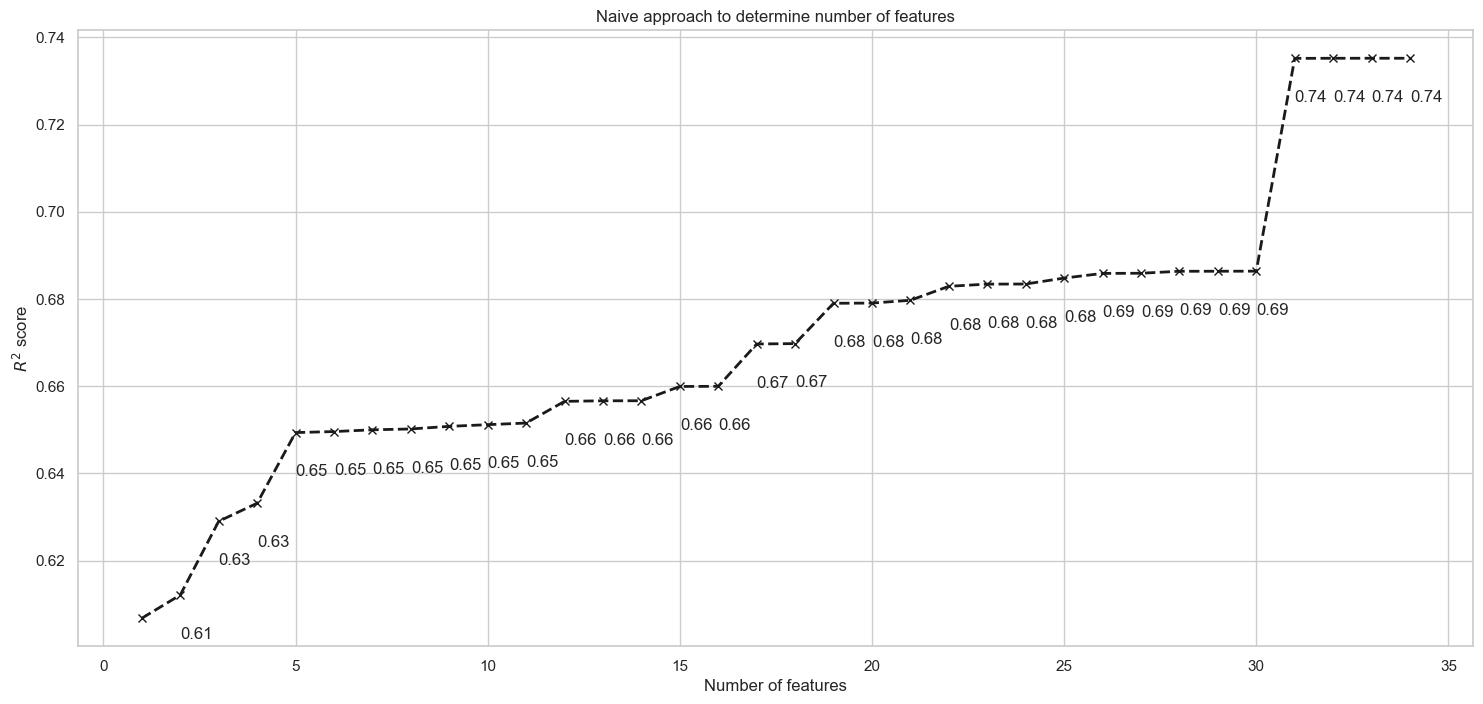

In [87]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(18, 8))
ax.plot(num_features,score,ls="--",lw=2,marker="x",c="k")
ax.set_xlabel("Number of features")
ax.set_ylabel(r"$R^2$ score")
ax.set_title("Naive approach to determine number of features")
for idx, s in zip(num_features,score):
    ax.annotate(f"{s:.2f}",xy=[idx,s-0.01])

#### Mean Squared Error

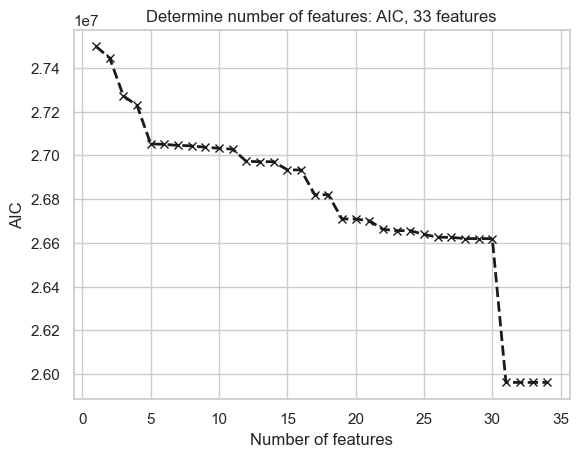

In [88]:
from sklearn.metrics import mean_squared_error

AIC = np.zeros(len(X.columns))
lr = LinearRegression()
for idx, nf in enumerate(num_features):
    rfe = RFE(lr,n_features_to_select=nf).fit(X,y)
    f = rfe.get_feature_names_out()
    new_X = X[f]
    nf_lm = lr.fit(new_X,y)
    y_pred = nf_lm.predict(new_X)
    mse = mean_squared_error(y,y_pred)
    AIC[idx] = 2.0*nf + len(X) * np.log(2.0*np.pi*(mse ** 2.0)) + len(X)

aic_features = np.argmin(AIC) + 1
fig, ax = plt.subplots(nrows=1,ncols=1)
ax.set_xlabel("Number of features")
ax.set_ylabel("AIC")
ax.set_title(f"Determine number of features: AIC, {aic_features} features")
ax.plot(num_features,AIC,ls="--",lw=2,marker="x",c="k")

In [89]:
# data with chosen features
X = X[selected_features]
y = model_df['heartrate']

#### Split data into Train & Test

In [90]:
x_train, x_test, y_train, y_test=train_test_split(X[selected_features],y,train_size=0.8, random_state=0)

In [91]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1554297, 7)
(1554297,)
(388575, 7)
(388575,)


In [92]:
x_train , y_train, x_test, y_test

(         activityid  wrist_temperature  chest_temperature  chest_gyroscope_y  \
 1490806           7            30.1250            35.0625          -0.194833   
 1229260           4            31.9375            36.5000           0.313727   
 1646493           6            31.5000            35.8750          -0.002786   
 1441577           4            32.5000            37.1250          -0.100996   
 1636021           6            31.9375            36.5625          -0.055055   
 ...             ...                ...                ...                ...   
 152315            1            30.6875            33.3750           0.004517   
 963395           16            34.7500            38.2500          -0.031369   
 117952            1            34.8750            36.6875           0.012851   
 1484405           7            30.2500            35.2500          -0.142107   
 305711            2            34.9375            36.8750           0.019521   
 
          chest_gyroscope_

In [93]:
# with sklearn
l_model=LinearRegression()
l_model.fit(x_train, y_train)

LinearRegression()

In [94]:
predictions=l_model.predict(x_test)
display(predictions)

array([ 99.56722011,  92.05030467, 100.36201246, ...,  87.84486728,
        89.88072342, 121.79005346])

In [95]:
error_pred=pd.DataFrame(columns=('Actual_data','Prediction_data'))
display(error_pred)

Empty DataFrame
Columns: [Actual_data, Prediction_data]
Index: []

In [96]:
error_pred['Actual_data']=y_test
#professor ans key

In [97]:
error_pred['Prediction_data']=predictions
# ans given by kid

In [98]:
error_pred.head()

Actual_data  Prediction_data
610957          85.0        99.567220
719614          91.0        92.050305
918734          90.0       100.362012
904060          93.0       102.715278
1098243        167.0       142.868672

In [99]:
error_pred.shape

(388575, 2)

In [100]:
from sklearn.metrics import *

In [101]:
r2_on_test=r2_score(y_test, predictions)
r2_on_test

0.6507379085690059

In [102]:
print("Linear Regression Coeffcient")
print(l_model.intercept_)

Linear Regression Coeffcient
108.66314110726648


In [103]:
coef_df1=pd.DataFrame(l_model.coef_,x_train.columns,columns=["Coefficient"])
coef_df1['Coefficient']=coef_df1['Coefficient'].apply(lambda x: '{:.2f}'.format(x))
display(coef_df1)

Coefficient
activityid               0.18
wrist_temperature       -3.79
chest_temperature        2.67
chest_gyroscope_y       -3.28
chest_gyroscope_z       -1.33
subject_id              -1.51
met                      8.81

In [104]:
# Fit the OLS model using statsmodels
features = sm.add_constant(X)
ols_model = sm.OLS(y, features).fit()

# Display OLS model summary
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:              heartrate   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                 5.177e+05
Date:                Mon, 08 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:24:24   Log-Likelihood:            -8.1369e+06
No. Observations:             1942872   AIC:                         1.627e+07
Df Residuals:                 1942864   BIC:                         1.627e+07
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               108.6354      0.29

The first part shows the output using sklearn and the second part displays output with statistical info using statsmodels.

Looking at both, we are getting consistent results from both.

### Observations:

#### Model Significance:
Given the statistical significance of the OLS regression model (F-statistic = 5.177e+05, p-value < 0.05), it can be concluded that the combined effect of the independent variables cannot be the result of chance.

<b>R-squared (R²):</b> R-squared value: 0.651.
This suggests that the independent variables in the model account for about 65.1% of the variability in the 'heartrate'. The model does not account for 34.9% of the variability that remains.

Coefficients: Constant Intercept: 108.6354
This is the calculated mean "heartrate" in the scenario when there are no independent variables.

<b>Activity ID</b>: 0.1851,
The "heartrate" is predicted to rise by 0.1851 units for every unit increase in "activityid."

<b>wrist_temperature</b>: -3.7927
3.7927 units are predicted to be lost from the "heartrate" for every unit increase in "wrist_temperature."
warmth of the chest: 2.6744

The anticipated increase in heart rate is 2.6744 units for every unit increase in <b>chest temperature.</b>

#### Summary
Our model is similar to an accurate heart rate predictor. Based on some parameters we measured, it can approximate 65.1% of the factors that cause the heart to beat faster or slower. Although it is very certain of its estimations, we still need to confirm a few details to be absolutely certain. This model is more reliable as it decreases the chances of overfitting due to feature selection which isnt the case if we use the model with all features.

# Section 3: Actionable Recommendations

The model will be used to help me design wearable technology, such as a fit watch, that can forecast heartrate and use that information to build an exercise model that is specific to each subject.

Since exercise has been linked to several unnatural deaths, that is what I hope to address with the aid of my model. I have no doubt that this approach will significantly contribute to addressing this problem and lowering the number of deaths from exercise-related causes in gyms.

My Actionable Recommendation based on the analysis I conducted would be as follows

<b>Significance Importance:</b>

Determine which features have the greatest influence by looking at the coefficient magnitudes. 
1. In my instance, "met" has a high positive coefficient, indicating that "heartrate" is strongly positively impacted by it.
2. There is a negative influence on "heartrat" as indicated by the strong negative coefficients of "wrist temperature" and "chest gyroscope y."
3. Pay attention to comprehending, maybe utilising, or controlling these influencing aspects.


<b>Multicollinearity</b>
1. Potential problems with multicollinearity among the independent variables are indicated by the huge condition number.
2. Examine how the independent variables are correlated. If significant correlations are discovered, think about selecting or transforming variables to address multicollinearity.


<b>Model Fit and Significance:</b>
1. Although the high R-squared number (65.1%) suggests a strong match, it's crucial to understand that 34.9% of the variability cannot be explained. 
2. More detailed information is required related to domain


<b>Outliers:</b>
I have not removed the outliers from my data as I didnt have enough domain knowledge about the same. Due to this the linear regression model is not that reliable.


<b>Model Improvement:</b>
1. Think about refining the model iteratively by including or deleting variables in light of more research or domain expertise.

<b>Further Investigation:</b>

There are more powerful models like logistic regression which could have given better results. Like this exploring additional analyses or models would be a best advice.


This interpretation offers a foundation for comprehending the connections between your dataset's properties and heartrate. Actionable recommendations can be guided by domain-specific knowledge and further investigation to improve the insights.

### Note: The code is fully functional, however occasionally it throws an error because of memory load because of enormous data.

# Section 4: References

Lecture notes and Panopto Recordings of Lectures 7,8,9, and 10

Tukey, J.W. (1977) Exploratory data analysis. Addison-Wesley.

https://chartio.com/learn/charts/box-plot-complete-guide/

https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/

https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/what-is-linear-regression/

https://www.youtube.com/watch?v=VvlqA-iO2HA

https://www.youtube.com/watch?v=SHa-58-n6ew

https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html#pandas.Series.interpolate

Adichie, J. N. [1967], “Estimates of regression parameters based on rank tests,” Ann. Math. Stat., 38, 894–904.

Belsey, D.A., Kuh, E., and Welsch, R.E. (1980). Regression Diagnostics: Identifying Influential Data and Sources of Collinearity. New York: John Wiley and Sons, Inc.

In [115]:
# write the notebook filepath here
# make sure that the notebook is also in the same directory as this code
filepath="DSRM Report 2 Final-277180.ipynb"

In [116]:
import io
from nbformat import read
with io.open(filepath, "r", encoding="utf-8") as f:
    nb=read(f, 4)
word_count = 0
for cell in nb["cells"]:
    if cell.cell_type == "markdown":
        word_count += len(cell["source"].replace("#", "").lstrip().split(" "))
print(f"Submission length is {word_count}")

Submission length is 2453
